<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 2
---------------------------------------------------------------
Student numbers: <span style="color:red">r0912072, r0708519, r0902589, u0142457</span>. (fill in your student numbers!)


**IMPORTANT NOTE 1: we encounter memory issues when running both the classification and segmentation task at the same time. Please read all our commented code as it also contains important parts of our implementation. We therefore submitted directly the csv of our results when doing submissions.**

**IMPORTANT NOTE 2: we encounter memory issues due to the length of the notebook (max 1MB in Kaggle). We thus had to remove some figures.**


In this group assignment your team will delve into some deep learning applications for computer vision. The assignment will be delivered in the same groups from *Group assignment 1* and you start from this template notebook. The notebook you submit for grading is the last notebook you submit in the [Kaggle competition](https://www.kaggle.com/t/d11be6a431b84198bc85f54ae7e2563f) prior to the deadline on **Tuesday 24 May 23:59**. Closely follow [these instructions](https://github.com/gourie/kaggle_inclass) for joining the competition, sharing your notebook with the TAs and making a valid notebook submission to the competition. A notebook submission not only produces a *submission.csv* file that is used to calculate your competition score, it also runs the entire notebook and saves its output as if it were a report. This way it becomes an all-in-one-place document for the TAs to review. As such, please make sure that your final submission notebook is self-contained and fully documented (e.g. provide strong arguments for the design choices that you make). Most likely, this notebook format is not appropriate to run all your experiments at submission time (e.g. the training of CNNs is a memory hungry and time consuming process; due to limited Kaggle resources). It can be a good idea to distribute your code otherwise and only summarize your findings, together with your final predictions, in the submission notebook. For example, you can substitute experiments with some text and figures that you have produced "offline" (e.g. learning curves and results on your internal validation set or even the test set for different architectures, pre-processing pipelines, etc). We advise you to first go through the PDF of this assignment entirely before you really start. Then, it can be a good idea to go through this notebook and use it as your first notebook submission to the competition. You can make use of the *Group assignment 2* forum/discussion board on Toledo if you have any questions. Good luck and have fun!

---------------------------------------------------------------
NOTES:
* This notebook is just a template. Please keep the five main sections, but feel free to adjust further in any way you please!
* Clearly indicate the improvements that you make! You can for instance use subsections like: *3.1. Improvement: applying loss function f instead of g*.


# 1. Overview
This assignment consists of *three main parts* for which we expect you to provide code and extensive documentation in the notebook:
* Image classification (Sect. 2)
* Semantic segmentation (Sect. 3)
* Adversarial attacks (Sect. 4)

In the first part, you will train an end-to-end neural network for image classification. In the second part, you will do the same for semantic segmentation. For these two tasks we expect you to put a significant effort into optimizing performance and as such competing with fellow students via the Kaggle competition. In the third part, you will try to find and exploit the weaknesses of your classification and/or segmentation network. For the latter there is no competition format, but we do expect you to put significant effort in achieving good performance on the self-posed goal for that part. Finally, we ask you to reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Sect. 5). It is important to note that only a small part of the grade will reflect the actual performance of your networks. However, we do expect all things to work! In general, we will evaluate the correctness of your approach and your understanding of what you have done that you demonstrate in the descriptions and discussions in the final notebook.

## 1.1 Deep learning resources
If you did not yet explore this in *Group assignment 1 (Sect. 2)*, we recommend using the TensorFlow and/or Keras library for building deep learning models. You can find a nice crash course [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# OS
import os

# Arrays & DataFrame
import numpy as np 
import pandas as pd


# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout, Flatten, Dense
from tensorflow.keras.models import load_model, Model
import tensorflow_addons as tfa

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split

# Data Augmentation
import albumentations as A
from albumentations.augmentations import transforms

# Math
import math

# Plots
from matplotlib import pyplot as plt 

# Progress Bar
from tqdm import tqdm

# Garbage Collector
import gc

# Display
from IPython.display import clear_output

# Set seed for reproducible results
SEED = 42

## 1.2 PASCAL VOC 2009
For this project you will be using the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. This dataset consists of colour images of various scenes with different object classes (e.g. animal: *bird, cat, ...*; vehicle: *aeroplane, bicycle, ...*), totalling 20 classes.

### 1.2.1. Load Data

In [2]:
TRAIN = False

if TRAIN:
    # Loading the training data
    train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/train_set.csv', index_col="Id")
    labels = train_df.columns
    train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
    train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
    print("The training set contains {} examples.".format(len(train_df)))

    # Show some examples
    fig, axs = plt.subplots(2, 20, figsize=(10 * 20, 10 * 2))
    for i, label in enumerate(labels):
        df = train_df.loc[train_df[label] == 1]
        axs[0, i].imshow(df.iloc[0]["img"], vmin=0, vmax=255)
        axs[0, i].set_title("\n".join(label for label in labels if df.iloc[0][label] == 1), fontsize=40)
        axs[0, i].axis("off")
        axs[1, i].imshow(df.iloc[0]["seg"], vmin=0, vmax=20)  # with the absolute color scale it will be clear that the arrays in the "seg" column are label maps (labels in [0, 20])
        axs[1, i].axis("off")

    plt.show()

    # The training dataframe contains for each image 20 columns with the ground truth classification labels and 20 column with the ground truth segmentation maps for each class
    train_df.head(1)

In [3]:
# Loading the test data
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/test_set.csv', index_col="Id")
labels = test_df.columns
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

# The test dataframe is similar to the training dataframe, but here the values are -1 --> your task is to fill in these as good as possible in Sect. 2 and Sect. 3; in Sect. 6 this dataframe is automatically transformed in the submission CSV!
test_df.head(1)

The test set contains 750 examples.


,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,img,seg
Id,,,,,,,,,,,,,,,,,,,,,
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,"[[[139, 130, 115], [136, 127, 112], [112, 102,...","[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."


### 1.2.2 Train Validation Split
We aim to split the train data into a train and validation set in a stratified way. It will ensure that the neural networks are trained and validated on a representative distribution of the labels. We avoid then 2 bad situations: the first one where the network is trained on some labels that do not appear in the validation set (potential for overfitting these labels); And the second one where the network never sees some labels in the training data and yet is evaluated on them in the validation set (potential for underfitting these labels).

This task is actually more difficult than applying the classic train_test_split of sklearn and specifying the stratifying values to be the combination of the label columns. Indeed, we have a multi-label classification problem and we want the distribution of **each individual label** to be kept identical both in the train and validation sets. We rely for that purpose on the *iterstrat* package (GitHub: https://github.com/trent-b/iterative-stratification)

In [4]:
params_cm = dict()
params_cm['seed'] = SEED # Seed for reproducibility
params_cm['validation_size'] = 0.15 # Size of validation set

In [5]:
params = dict()
params['seed'] = SEED # Seed for reproducibility
params['validation_size'] = 0.15 # Size of validation set

In [6]:
if TRAIN:
    # Initial information on and distribution of the labels in train_df
    print("Max number of labels assigned to one image: ", np.max(np.sum(train_df[labels], axis=1)))
    print("Average number of labels assigned to one image: ", np.mean(train_df[labels], axis=0).sum())
    print("Distribution of each label:")
    np.mean(train_df[labels], axis=0)

#### Iterative Multi-Label Stratified Split
- Paper: https://link.springer.com/chapter/10.1007/978-3-642-23808-6_10
- GitHub: https://github.com/trent-b/iterative-stratification

The algorithm can be decomposed in a few main steps. 

At first, it sets the desired number of examples at each fold to be equal to the number of samples divided by the number of folds. It then computes the desired number of samples of each label at each fold such that the distribution of each label would remain the same across all folds.

The algorithm then operates iteratively for all samples as follows. It looks for the label with the fewest (but at least one) remaining samples, breaking ties randomly. It finds the subset(s) with the largest number of desired samples for this label, breaking ties by considering the largest number of desired examples, breaking further ties randomly. It assigns the current sample to this subset. 

In [7]:
if TRAIN:
    !pip install iterative-stratification
    from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [8]:
def multilabel_stratified_train_test_split(X, test_size, stratify, random_state=None):
    """Iteratively stratified train/test split
    Parameters
    ----------
    test_size : float, [0,1]
        the proportion of the dataset to include in the test split, the rest will be put in the train set
    Returns
    -------
    train, test
        stratified division into train/test split
    """
    stratifier = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=test_size, random_state=random_state)
    train_indexes, test_indexes = next(stratifier.split(X, stratify))
    train = X.iloc[train_indexes, :]
    test = X.iloc[test_indexes, :]
    return train, test

In [9]:
if TRAIN:
    train_set, validation_set = multilabel_stratified_train_test_split(train_df,
                                                                       test_size=params['validation_size'], 
                                                                       stratify=train_df[labels],
                                                                       random_state=params['seed'])

In [10]:
if TRAIN:
    print(f"Train set length: {len(train_set)}")
    print(f"Validation set length: {len(validation_set)}")

Thanks to the iterative multi-label stratified split algorithm, the difference in the distribution of each label between the initial dataset and the train and validation splits is kept to a minimum.

In [11]:
if TRAIN:
    print("Max number of labels assigned to one image: ", np.max(np.sum(train_set[labels], axis=1)))
    print("Average number of labels assigned to one image: ", np.mean(train_set[labels], axis=0).sum())
    print("Difference in the distribution of each label between the initial train_df and the new train_set:")
    diff_dist = (np.mean(train_set[labels], axis=0) - np.mean(train_df[labels], axis=0)) * len(train_set)
    print(diff_dist)
    print(np.sum(abs(diff_dist)))

In [12]:
if TRAIN:
    print("Max number of labels assigned to one image: ", np.max(np.sum(validation_set[labels], axis=1)))
    print("Average number of labels assigned to one image: ", np.mean(validation_set[labels], axis=0).sum())
    print("Difference in distribution of each label between the initial train_df and the new validation_set:")
    diff_dist = (np.mean(train_df[labels], axis=0) - np.mean(validation_set[labels], axis=0)) * len(validation_set)
    print(diff_dist)
    print(np.sum(abs(diff_dist)))

## 1.3 Your Kaggle submission
Your filled test dataframe (during Sect. 2 and Sect. 3) must be converted to a submission.csv with two rows per example (one for classification and one for segmentation) and with only a single prediction column (the multi-class/label predictions running length encoded). You don't need to edit this section. Just make sure to call this function at the right position in this notebook.

In [13]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

# 2. Image classification
The goal here is simple: implement a classification CNN and train it to recognise all 20 classes (and/or background) using the training set and compete on the test set (by filling in the classification columns in the test dataframe).

## 2.1. Configuration

### 2.1.1 Fix Seeds For Reproducibility

In [14]:
# Fix seeds and create tensorflow session for reproducible results
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-05-24 23:58:52.124046: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-24 23:58:52.180151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 23:58:52.291696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 23:58:52.292973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

### 2.1.2 Load Strategy For CPU, TPU, GPU Acceleration

In [15]:
# In case you want to train on TPU, uncomment this 
# and use the following with-statement each time you refer to the model you want to train ---- with strategy.scope():

# try:
#     # TPU detection
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
# else:
#     # By default, GPU or CPU
#     strategy = tf.distribute.get_strategy()

### 2.1.3 Configure Hyperparameters

In [16]:
params['image_size'] = (375, 500, 3) # To resize the images to a common size
params['num_classes'] = 20 # Number of classes
params['max_epochs'] = 20 # Number of epochs for training the model
params['batch_size'] = 64 # Batch size
params['lr'] = 0.005 # Learning rate
params['lr_decay_rate'] = 0.90 # Decay rate of the learning rate under an exponential decay scheduler
params['clipvalue'] = 0.5 # Clip the gradient values to prevent exploding gradient
params['augm_model'] = tf.keras.Sequential([ # data augmentation model
    tf.keras.layers.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomZoom(height_factor = 0.1, width_factor = 0.1),
    tf.keras.layers.RandomTranslation(height_factor = 0.15, width_factor = 0.05, fill_mode='wrap'),
    tf.keras.layers.RandomRotation(factor = 0.05, fill_mode='wrap'),
    tf.keras.layers.RandomContrast(factor = 0.5),    
])

2022-05-24 23:58:56.326543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 23:58:56.327486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 23:58:56.328155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 23:58:56.329081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 23:58:56.329750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

#### **Influence of hyperparameters**

A downside of these neural nets is that they come with loads and loads of hyperparameters. Let's take a look at some of them and see how they influence the training.

##### **Batch Size**

The batch size is often chosen to be 32 or 64 as a rule of thumb.

The bigger the batch size, the faster the training time as it takes advantage of parallel computations from GPU/TPU. It allows one to then have more time to tune other parameters. The batch size is nevertheless limited by memory resources. 

It also influences how stochastic gradient descent (SGD) and its variants (such as Adam) behave. With a low batch size, more room is given to the stochastic properties of SGD. As batch stochastic gradient descent does not explicitly minimize the gradient of the error function but rather an approximation of it computed from a batch/subset of data samples, it allows a better exploration of the loss surface but may lead to difficulties to convergence to a global optimum.

In gradient descent, we explicitly minimize the error functions of the training and validation data. However, the stochastic property of SGD is desirable as in machine learning, we do not explicitly want to minimize these error functions. Those are just approximations of the generalization error which we really want to minimize. Some randomness allows thus to achieve better generalization than strictly sticking to minimizing the train and validation errors.

##### **Learning rate**

Choosing an appropriate learning rate is very important. If it is too big, the weights will jump around too much and will not be able to settle in an optimum. If it is too small, the training will be slow and may converge to suboptimal local optimum from which it will not be able to escape. Usually the way to go is to test out multiple values on a log-scale and go from there. Another good practice to try out is the use of a scheduler. The idea is that at the start of the training, the net learns the 'general characteristics' of the image, thus we should start with a bigger learning rate that we gradually make smaller as the net starts learning finer details. It will then make smaller improvements per epoch and it will help the network not to overfit too soon in the training.

In the figure below the learning curve is shown for a pretrained model with the lr = 0.01. The curve remains stagnant indicating that the network isn't able to learn a thing. This shows us that we should take a lower learning curve.

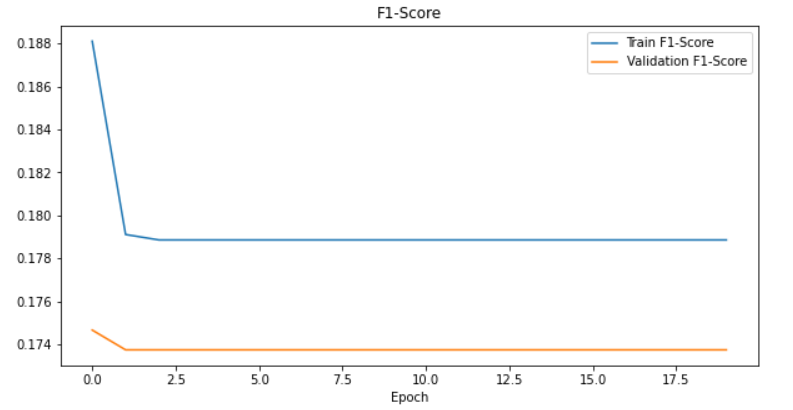

#### **Data augmentation**

When learning from small datasets, it is usually a good idea to perform data augmentation. This is a way of randomly applying image transformation to the data during training. This way the net always has unique images to learn from and does not repeatedly encounter the exact same images, which would likely lead to overfitting.

What operations should be applied to the data are application dependent. The only rule of thumb is that the transformation should still produce realistic images that could be found as such in the original dataset.

We make use of 5 transformations in our case (in bold).

When classifying VOC images, it might not be a good idea to flip images vertically, since important disciminative information can be learned from the standing position of most objects (such as cars, people, potted plants, ...). The upside down objects are not probable to often occur. **Random horizontal flips** however are helpfull in our case, because such flipped objects still represent realistic examples.

CNN-based architectures provide some form of translation equivariance thanks to weight sharing in convolutional layers. Weight sharing allows the network to learn the same local features in several regions of an image. And limited translation invariance thanks to max pooling layers. Max Pooling passes over the max value in its receptive field regardless of its spatial position. However, CNN-based networks can still be made even more robust to translation by applying **random translations**.

CNN are not naturally robust to rotation and scaling. However, objects that are tilted and that are of different scales can be found in the dataset. We should enhance robustness to those 2 transformations with **random rotation** to small angle variations. **Random zoom** helps to make our network robust to small scaling changes and thus to learn object features of different size.

Finally, depending on the time of the day, the season and the weather, illumination and color can vary. We should allow our network to experience these variations in the training. We therefore apply **random contrast** variations.

The fillmode was chosen to be 'nearest'. This smears out the nearest pixel to fill in for space created by translating or rotating the image. Alternatives like 'wrap' were tried, but resulted in poorer performance. Presumably because the hard edge that a wrap creates gets detected as a feature and confuses the network during training.

In [17]:
if TRAIN:
    # illustration of how fillmode='wrap' creates a hard edge in the image
    augm_wrap = Sequential([
        tf.keras.layers.RandomTranslation(0.2,0.2,fill_mode='wrap'),
        tf.keras.layers.RandomRotation(0.05,fill_mode='wrap')
    ])

    augm_nearest = Sequential([
        tf.keras.layers.RandomTranslation(0.2,0.2,fill_mode='nearest'),
        tf.keras.layers.RandomRotation(0.05,fill_mode='nearest')
    ])

    f, axarr = plt.subplots(1,2, figsize=(15,15))

    axarr[0].imshow(augm_wrap(train_df['img'][0]))
    axarr[0].title.set_text('fill mode = wrap')
    axarr[1].imshow(augm_nearest(train_df['img'][0]))
    axarr[1].title.set_text('fill mode = nearest')

## 2.2. Load and Visualize Data

### 2.2.1. Data Loader
Retrieve and preprocess (eg: scaling, resizing, reformatting, data augmentation) the data in a common and standardize way. This class inherits from the Sequence class in keras. Every feature implemented in the getitem-method will be applied each epoch during the training.

In [18]:
class DataLoader(keras.utils.Sequence):
    def __init__(self, images, labels=None, params=None, batch_size=None, data_augmentation=False):
        self.images = images / 255. # Scale the images to range [0, 1]
        self.labels = labels 
        self.data_augmentation = data_augmentation
        self.train = (labels is not None)
                
        if params != None: 
            self.batch_size = params['batch_size']
            self.images = np.array([tf.image.resize(image, params['image_size'][:2]) for image in self.images]) # Resize image

        if batch_size != None:
            self.batch_size = batch_size

    def __len__(self): 
        'Get length of the data loader in number of batches'
        return int(np.floor(len(self.images) / self.batch_size)) # floor the size (excludes the last batch if it is incomplete)

    def __getitem__(self, index):
        'Retrieve a specific batch of data'
        images_batch = self.images[index*self.batch_size:(index+1)*self.batch_size]
        if self.train:
            labels_batch = self.labels[index*self.batch_size:(index+1)*self.batch_size]
            
        if self.data_augmentation:
            images_batch = np.array([params['augm_model'](image) for image in images_batch])
        
        if self.train: 
            return (images_batch, labels_batch)
        return (images_batch, -np.ones(images_batch.shape[0])) # if test set, we do not have any labels, so we replace them by -1

Notice that data augmentation is only applied to the training set and not the validation set. This is because we want the validation set to be as representative as possible for the test set. That way the parameters we tune on the validation set will also perform well on the test set.

In [19]:
if TRAIN:
    train_loader = DataLoader(train_set.loc[:, 'img'].values,
                              train_set.loc[:, labels].values,
                              params=params, data_augmentation=True)
    validation_loader = DataLoader(validation_set.loc[:, 'img'].values,
                                   validation_set.loc[:, labels].values, 
                                   params=params, data_augmentation=False)

In [20]:
classification_test_loader = DataLoader(test_df.loc[:, 'img'].values,
                                         None, 
                                         params=params, batch_size=1, data_augmentation=False)

### 2.2.2. Visualize Data
Visualize a few samples after preprocessing

In [21]:
def label_nums_to_strings(label_nums, labels):
    'Convert categorical labels into readable string categories '
    return [labels[j] for j in range(len(labels)) if label_nums[j] == 1]

In [22]:
def plot_batch(images_batch, labels_batch, str_labels, predicted_labels=[], cols=5, figsize=None):
    'Plot a batch of samples with its corresponding labels. Green labels for correctly predicted outputs, red otherwise'
    rows = int(np.ceil(len(labels_batch) / cols))
    if figsize is None:
        figsize = (cols * 3, rows * 3)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    i = 0
    for image, label in zip(images_batch, labels_batch):
        if predicted_labels:
            predicted_str_labels = "\n".join(label_nums_to_strings(predicted_labels[i], str_labels))
        true_str_labels = "\n".join(label_nums_to_strings(label, str_labels))
        title = predicted_str_labels + '\n---\n' + true_str_labels if predicted_labels else true_str_labels
        color = "green" if not predicted_labels or label == predicted_labels[i] else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(title, color=color)
        ax.ravel()[i].set_axis_off()
        i += 1
    plt.tight_layout()
    plt.show()

Run the cell below to observe some images from the training set that are augmented.

In [23]:
if TRAIN:   
    visualize_loader = DataLoader(train_set.loc[:, 'img'].values,
                                  train_set.loc[:, labels].values,
                                  params=params,
                                  batch_size=20, 
                                  data_augmentation=True, shuffle=False)
    batch = visualize_loader[0]
    plot_batch(batch[0], batch[1], str_labels=labels, cols=5)

## 2.3 Classification

### 2.3.1 Custom model

The first approach we take is that of a custom model. We base ourselves on the architecture of AlexNet. AlexNet was an early neural net that was very succesfull in the ImageNet competition, then beating its competition with 10%.

original paper: https://scholar.google.com/citations?view_op=view_citation&hl=en&user=xegzhJcAAAAJ&citation_for_view=xegzhJcAAAAJ:u5HHmVD_uO8C
used tutorial: https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

The architecture consists first of some convolution blocks performing the feature extraction and ends with some fully connected layers, that perform the classification. A convolutional block consists of:

- 2D convolutional layer: At the start, a random kernel is convolved around the image. The values in the kernel are the weights that need to be optimized. During training, the optimal kernel for the application is learnt by the network.

- BatchNormalization: The layer's inputs are recentered and rescaled. This makes the network faster and more stable.

- ReLU Activation layer: ReLU stands for Rectified Linear Unit. An intuitive interpretation of ReLu could be that all negative values are 'equally wrong'. For positive values the activation is proportional. The ReLU has experimentally been found to work well on image classification and other deep learning applications. It noticeably introduces non-linearity in a network and is not saturated (it tends towards infinity for large positive values) as opposed to a tanh or sigmoid activation function. It prevents the gradient from vanishing as opposed to when layers with saturated activations are stacked. It is also computationally efficient as ReLU explicitly deactivates neurons that yield negative values.

- Max Pooling: Max Pooling is a way of reducing the dimension of the features and make them translation-independent.

After a set of convolutional blocks follows the classification part. It consists of the following layers:

- Flatten: bridge between convolutional and dense block. Flattens the features into one array.
- Dense: fully interconnected layer. It interconnects and extracts the most meaningfull features for classification.
- ReLU activation
- Dropout: this layers are a simple way to apply some regularization. It deactivates a ratio of neurons, from the previous layer, at random at each epoch (sparsness property). It encourages the model to learn several independent paths to discriminate classes at each epoch. It can also be seen as a very efficient way of performing model averaging with neural networks.

In [24]:
if TRAIN:
    custom_model = Sequential([

        # first convolutional block
        Conv2D(filters=96, input_shape=params_cm['image_size'], kernel_size=(11,11), strides=(4,4), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),

        # Second conv block
        Conv2D(filters=128, kernel_size=(5, 5), strides=(1,1), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same'),

        #3rd Convolutional Layer
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'),
        BatchNormalization(),
        Activation('relu'),

        #Passing it to a Fully Connected layer
        Flatten(),
        # 1st Fully Connected Layer
        Dense(512), #, input_shape=(32,32,3,)),
        BatchNormalization(),
        Activation('relu'),
        # Add Dropout to prevent overfitting
        Dropout(0.4),

        #3rd Fully Connected Layer
        Dense(256),
        BatchNormalization(),
        Activation('relu'),
        #Add Dropout
        Dropout(0.4),

        #Output Layer
        Dense(params_cm['num_classes']),
        BatchNormalization(),
        Activation('sigmoid'),
    ])

Let's have a look at an overview of the model.

In [25]:
if TRAIN:
    custom_model.summary()

Configuring the model by choosing appropriate metrics and loss functions. Altough multiple classes are present, we are in a multi-label context, we should thus rely on Binary Cross-Entropy instead of Categorical Cross-Entropy. In this way, we cast the multi-label multi-class problem as multiple binary classification problems of each label.

In [26]:
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')
# f1_score = tfa.metrics.F1Score(num_classes=20, average='weighted', threshold=0.5)
params_cm['lr'] = 0.001
metrics = [precision, recall] 
optimizer = keras.optimizers.Adam(learning_rate=params_cm['lr'])
if TRAIN:
    custom_model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=metrics)

Train the model using the train_loader and validation_loader.

In [27]:
if TRAIN:
    history = custom_model.fit(
        train_loader,
        validation_data = validation_loader,
        epochs = params_cm['max_epochs'],
        shuffle = True,
    )

Plot the loss on the training and validation data. We should pay attention that we effectively learn at each epoch, i.e. the training loss decreases. And while the training loss decreases, the validation decreases as well. Otherwise, we would encounter a scenario of overfitting.

In [28]:
if TRAIN:
    fig = plt.figure(figsize=(10, 5))
    #print(history.history.keys())

    plt.plot(np.log(history.history['loss']), label='Train Log(Loss)')
    plt.plot(np.log(history.history['val_loss']), label='Validation Log(Loss)')
    plt.title('Log(Loss)')
    plt.xlabel('Epoch')
    plt.legend()
    # plt.savefig('./classification_loss.png')
    plt.show()

On top of the loss curves, we look at the f1-score. It promotes that all labels be equally well classified and balances precision and recall. It is especially usefull to maximise the f1-score in an imbalanced dataset. Furthermore, the competition metric on Kaggle is **the dice score which is equivalent to the f1-score** under binary classification. Weighted f1-score is here used to generalize the concept to multi-label classification.

Hereunder, we plot the f1-score on the validation and training data and we again pay attention to any sign of overfitting.

In [29]:
if TRAIN:
    fig = plt.figure(figsize=(10, 5))
    plt.plot(history.history['f1_score'], label='Train F1-Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
    plt.title('F1-Score')
    plt.xlabel('Epoch')
    plt.legend()
    # plt.savefig('./classification_f1_score.png')
    plt.show()

### 2.3.2 Pretrained Model
- The classification model is based on a top-less **ResNet50V2 as backbone**. It allows to balance between good accuracy, moderate model size and fast inference speed to ensure that we obtain decent results despite the limited resources on Kaggle.
- We reduce the number of dimensions of the embeddings with a GlobalAveragePool2D layer
- We only **finetune the custom top layers** (2 Dense layers) of the model for training speed on Kaggle GPU
- We add a **sigmoid activation** instead of a softmax in the final layer such that each label is assigned an independent probability between 0 and 1 (the probabilities of all the labels do not sum to 1 as we are in a multi-label classification task)
- We rely on a **binary cross entropy loss** as a multi-label classification problem can be seen as the combination of multiple binary classification problems (one for each label)
- We make use of the **Adam optimizer** for its known properties of adaptive learning rate and momentum (accelerates the gradient descent in the valleys of the loss curves and avoids to get stuck in local mimima)
- We further improve the learning rate with an **exponential decay scheduler** that progressively reduces the learning rate as we come closer and closer to the potential global minimum
- We implements some regularization techniques via **dropout layers** and **weight and bias l2-decay** on the dense layers
- We apply **gradient clipping** (clipping the gradient values to a given threshold) to prevent exploding gradient
- We perform **model selection based on optimal validation f1-score**
- The best model is saved automatically during training (can be assimilated to the regularization technique of early stopping)

In [30]:
# Fix seeds and create tensorflow session for reproducible results
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-05-24 23:59:13.442611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 23:59:13.444591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 23:59:13.445366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 23:59:13.445970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 23:59:13.446541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [31]:
reg_penalty = 0.0001
drop_prob = 0.2

image = tf.keras.layers.Input(shape = params['image_size'])

# Load as backbone a topless pretrained ResNet50V2
resnet = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=image,
    input_shape=params['image_size'],
    pooling=None,
)

vgg = tf.keras.applications.VGG19(
    include_top = False,
    weights="imagenet",
    input_tensor=image,
    input_shape=params['image_size'],
    pooling=None,
)

pretrained_model = resnet

image = tf.keras.layers.Input(shape = params['image_size'])

# Fix the backbone layer's parameters, we will not train them
for layer in pretrained_model.layers:
    layer.trainable = False

x = pretrained_model(image)
# Global Average Pooling to reduce the number of dimensions of the features
x = tf.keras.layers.GlobalAveragePooling2D()(x) 
x = tf.keras.layers.Dropout(drop_prob)(x)
x = tf.keras.layers.Dense(512,
                           activation='relu',
                           #kernel_initializer = 'he_uniform',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_penalty),
                           bias_regularizer=tf.keras.regularizers.l2(reg_penalty))(x) 
x = tf.keras.layers.Dropout(drop_prob)(x)


# A dense layer to interconnect the remaining features together and extract from them the labels to predict
# with a sigmoid activation function for multi-label classification, i.e. independent probabilities
# computed for each output. (whereas a softmax layer would adapt the probabilities of all outputs such that
# they sum to one)
output = tf.keras.layers.Dense(params['num_classes'], 
                               activation='sigmoid', 
                               #kernel_initializer = 'he_uniform',
                               kernel_regularizer=tf.keras.regularizers.l2(reg_penalty),
                               bias_regularizer=tf.keras.regularizers.l2(reg_penalty))(x) 
model = tf.keras.models.Model(inputs = [image], outputs = [output]) 
model._name = 'classification_model'


80150528/80134624 [==============================] - 1s 0us/step


In [32]:
class ClassificationModel:
    """
    Classification model: 
        - assumes an input can have multiple labels
        - rely on a pretrained ResNet50V2 as backbone
        - finetune only the custom top layers of the model for speed
        - trained with:
            - a sigmoid activation in the final layer
            - a binary cross entropy loss
            - an Adam optimizer
            - an exponential decay scheduler that progressively reduces the learning rate
        - regularization via dropout layers and weight and bias l2-decay on the dense layers
        - model selection based on an optimal f1-score
        - the best model is saved automatically during training
    """
    def __init__(self, params, model, loss, optimizer, metrics):
        self.params = params
        
        # Load Model Architecture
        self.model = model
        
        # Binary Cross-Entropy Loss because the problem is a multi-label classification task
        self.loss = loss

        # Adam optimizer
        self.optimizer = optimizer
        
        # Metrics
        self.metrics = metrics 

        # Compile the model
        self.model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
        
        # Get callbacks
        self.callbacks = self.get_callbacks(params)
    
    def get_callbacks(self, params):
        callbacks = []
        # Learning Rate Scheduler
        scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=params['lr'],
                                                                   decay_steps=1,
                                                                   decay_rate=params['lr_decay_rate'],
                                                                   staircase=True)
        scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        callbacks.append(scheduler_callback)
        
        # Save the best model (checks if the model improves based on the validation f1-score after each epoch)
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                            './model/best-classification-model.h5',
                                            monitor='val_f1_score',
                                            verbose=1,
                                            save_best_only=True,
                                            save_weights_only=False,
                                            mode='max',
                                            save_freq='epoch',
                                            options=None,
                                            initial_value_threshold=None)
        callbacks.append(checkpoint_callback)
        return callbacks


    def fit(self, train_data, validation_data):
        """
        Adjusts the class ratio variable to the one observed in y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        y: list of arrays - n x (nb_classes)

        Returns
        -------
        self
        """
        history = self.model.fit(train_data, 
                                validation_data=validation_data,
                                epochs = self.params['max_epochs'],
                                batch_size = None,
                                shuffle = True,
                                callbacks = self.callbacks)
        return history
        
    
    def predict(self, X):
        """
        Predicts for each input a label.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        y_pred: list of arrays - n x (nb_classes)
        """
        distributions = self.model(X)
        return [[int(p > 0.5) for p in distribution] for distribution in distributions]
    
    def __call__(self, X):
        return self.predict(X)

Choosing the right optimizer and loss function for the job is an important part of designing the CNN. The Adam optimizer is well-known to be a good allround default choice. There are two lossfunctions that could apply here:

* categorical crossentropy: the CNN is trained to try and solve the problem in 1 go.
* binary crossentropy: the multi-class problem is viewed as a sequence of binary class problems.

Through experimentation we found that binary crossentropy yields better results. This is illustrated by the graphs below (respectively when binary and categorical loss was used). The loss using categorical explodes (second graph).

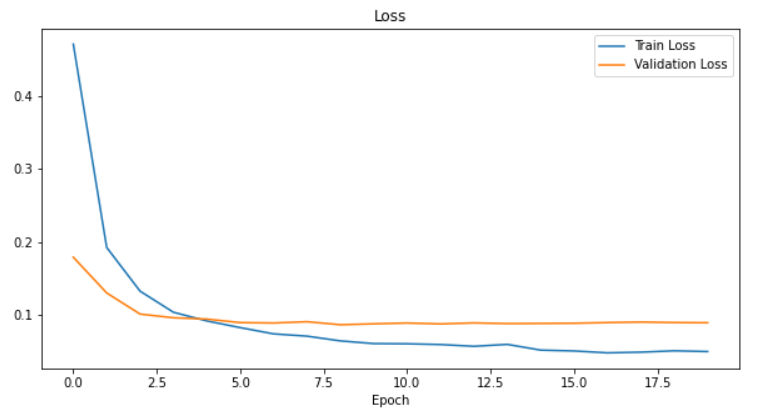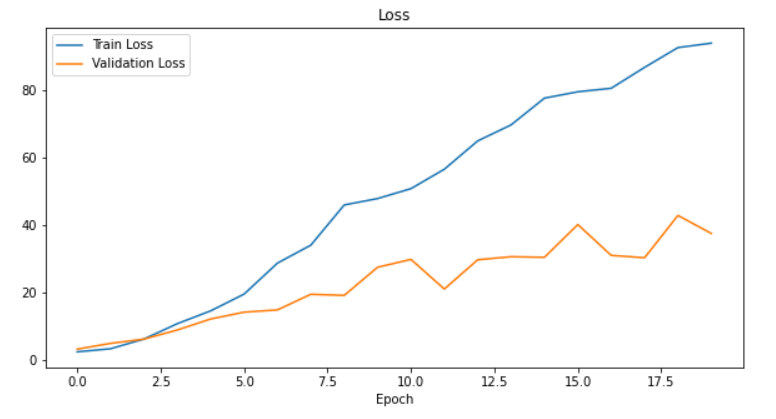

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate = params['lr'], clipvalue=params['clipvalue'])
loss = tf.keras.losses.BinaryCrossentropy()

# Monitor the learning rate
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32)
    return lr
lr_metric = get_lr_metric(optimizer)

# Monitor the precision, recall and f1-score
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')
f1_score = tfa.metrics.F1Score(num_classes=20, average='weighted', threshold=0.5)

metrics = [f1_score, precision, recall, lr_metric] 

classification_model = ClassificationModel(params, model, loss, optimizer, metrics)

In [34]:
# Visualize model
# print(classification_model.model.summary())
# tf.keras.utils.plot_model(classification_model.model, show_shapes=True)

### 2.3.2. Train and Validate
We train the network and keep track of the train and validation losses and metrics. We then plot them to keep track of potential overfitting situation, i.e. if the train loss/metrics improve while the validation ones do not. We tune the hyperparameters and adapt the regularization to obtain a good convergence and performance

In [35]:
if TRAIN:
    history = classification_model.fit(train_loader, validation_loader)

In [36]:
if TRAIN:
    fig = plt.figure(figsize=(10, 5))
    #print(history.history.keys())

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    # plt.savefig('./classification_loss.png')
    plt.show()

    fig = plt.figure(figsize=(10, 5))
    plt.plot(history.history['f1_score'], label='Train F1-Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
    plt.title('F1-Score')
    plt.xlabel('Epoch')
    plt.legend()
    # plt.savefig('./classification_f1_score.png')
    plt.show()

### 2.3.2. Test
Load the best model (highest f1-score on the validation set) and predict the labels of the test samples

In [37]:
# Load the best model
classification_model.model.load_weights('../input/voc-classifier/best-classification-model.h5')

In [38]:
# Predict on the test set
test_df.loc[:, labels] = [classification_model.predict(np.expand_dims(classification_test_loader[i][0][0], axis=0))[0] for i in tqdm(range(len(classification_test_loader)))]
test_df.head(1)

100%|██████████| 750/750 [00:53<00:00, 13.90it/s]


,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,img,seg
Id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,"[[[139, 130, 115], [136, 127, 112], [112, 102,...","[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, ..."


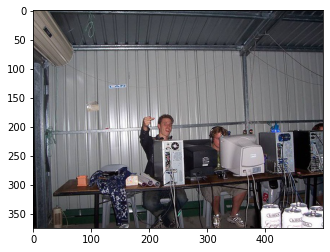

In [39]:
plt.imshow(test_df.loc[0, 'img'])

Let's now plot some examples of our predictions. Be sure to first fill run the '.predict'-cell above, so the labels in the test_df dataframe aren't empty.

['cat']


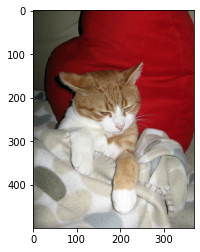

['aeroplane']


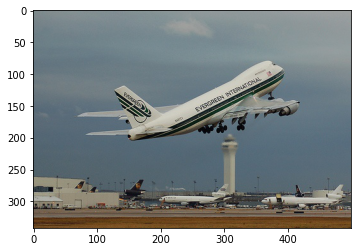

['aeroplane']


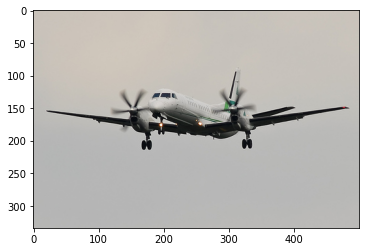

['bottle', 'person']


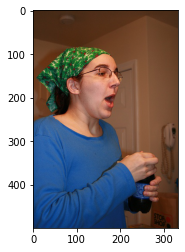

['boat']


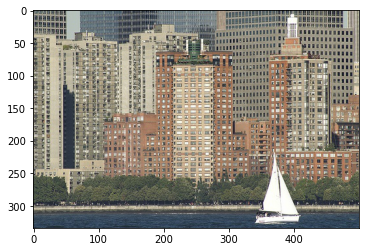

In [40]:
for i in range(5):
    idx = np.random.choice(test_df.shape[0])
    
    label_nums = test_df[labels].iloc[idx].values
    pred_labels = label_nums_to_strings(label_nums, labels)
    print(pred_labels)
    plt.imshow(test_df.loc[idx, 'img'])
    plt.show()

## 2.4 Discussion

### 2.4.1 Regularization

Regularization refers to a range of techniques that lower the complexity of a machine learning model. It can prevent overfitting and improve the model performance. There are 3 popular regularization techniques for neural networks called L1 regularization, L2 regularization, and drop out. L1 regularization shrinks less immportant feature's coefficients to zero (sparseness property). L2 regularization decreases less immportant feature's coefficients towards zero but not to zero exactly and penalises outliers stronger (due to the square operation). Dropout means that each neuron of a specific hidden layer of the neural network will be shut off with a certain probability p.

Lets first test out the drop out layers with different drop out probabilities p. We tried 3 different values for p and plotted the results below.

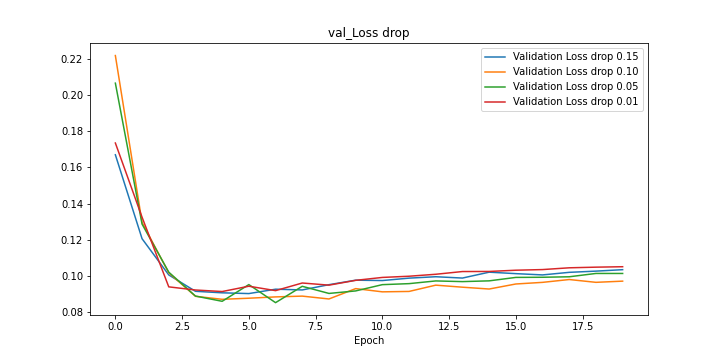
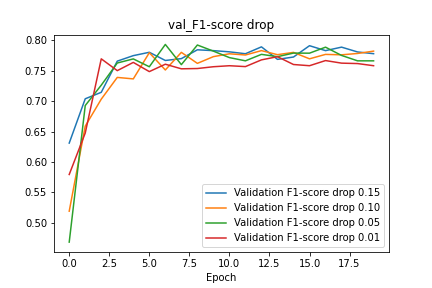

From the graphs above we can see that there isn't much of a difference between the different drop out probabilities. We will use dropout probability 0.1.

Lets now try out L2 regularization with different values for the decay rate on top of the drop out layers. We tried 6 different weight and bias decay rates and plotted the results below.

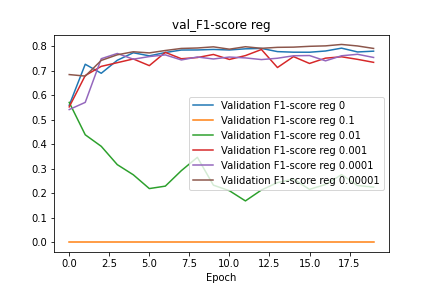
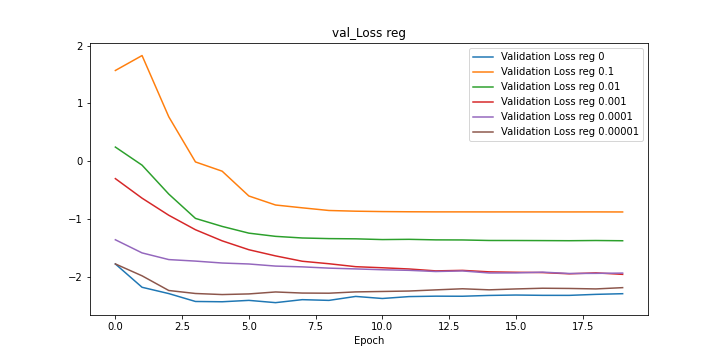

In these graphs we can clearly see big differences between the different decay rates. A too high decay rate of 0.1 or 0.01 reduces the complexity of the neural net so much that the neural net can not capture the complexity of the problem anymore. From the other values we can derive that for this problem with the already in place drop out layers the less regularization the better. We get the best results from a decay rate of 0.00001.

### 2.4.2 Comparison VGG19 vs ResNet

Our classification results rely heavily on the pretrained model used as a backbone, so naturally we also tested different pretrained models. We tried VGG-19 with the same configuration as ResNet, and then tried to play around with the configurations to get the best results possible. The best results we got from the model are plotted below, but as we can see these results are nowhere close to the results we got with the ResNet model.

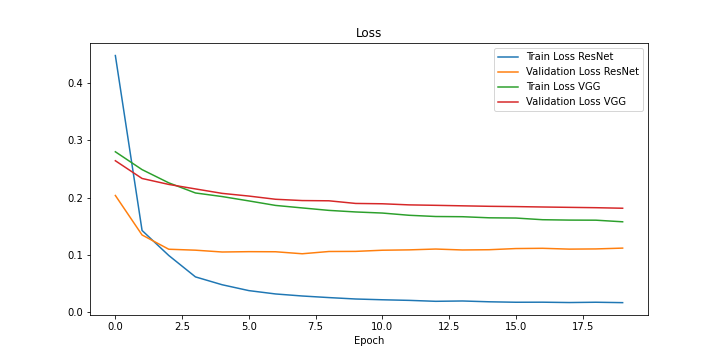
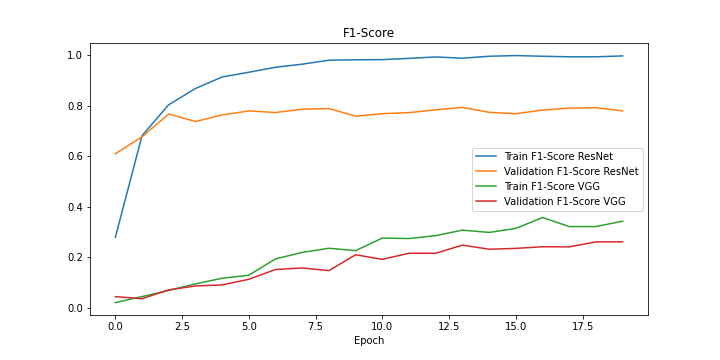

### 2.4.3 Final Model

From the previous analysis we find our final model. The first layer is our input layer, which has a size equal to the number of pixels in the input images. Then we have the pretrained top-less ResNet50V2 model as a backbone. Next is a global average pooling layer to reduce the number of parameters in the model. It takes the average of each feature map. We added two drop out layers to avoid overfitting, with a dense layer in between. The last layer is our output layer, which maps the ouputs of the previous layers to our 20 output classes.

In [41]:
# tf.keras.utils.plot_model(classification_model.model, show_shapes=True)

# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). Use the training set to train your CNN and compete on the test set (by filling in the segmentation column in the test dataframe).

## 3.1. Fix Seeds For Reproducibility

In [42]:
# Fix seeds and create tensorflow session for reproducible results
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-05-25 00:00:33.427995: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:00:33.429342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:00:33.430348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:00:33.431276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:00:33.431918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## 3.2. Load Strategy For CPU, TPU, GPU Acceleration

In [43]:
# In case you want to train on TPU, uncomment this 
# and use the following with-statement each time you refer to the model you want to train ---- with strategy.scope():

# try:
#     # TPU detection
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.TPUStrategy(tpu)
# else:
#     # By default, GPU or CPU
#     strategy = tf.distribute.get_strategy()

## 3.3. Unet

### 3.3.1. Configure Hyperparameters

In [44]:
params['image_size'] = (128, 128, 3) # We downsize the images to reduce the complexity of the model, reduce the memory needs and fasten the training
params['num_classes'] = 20 + 1 # Number of classes = 20 classes + 1 background
params['max_epochs'] = 50 # Number of epochs for training the model
params['batch_size'] = 32 # Low batch size takes more time to run and gives more weight to the stochastic property of SGD
params['lr'] = 0.001 # Learning rate
params['lr_decay_rate'] = 0.995 # Decay rate of the learning rate under an exponential decay scheduler
params['clipvalue'] = 0.5 # Clip gradient values to prevent exploding gradients

### 3.3.2. Load and Visualize Data

#### 3.3.2.1. Data Loader
Retrieve and preprocess (eg: scaling, resizing, reformatting, data augmentation) the data in a common and standardize way

In [45]:
class SegmentationDataLoader(keras.utils.Sequence):
    def __init__(self, images, segmentation_masks=None, params=None, batch_size=None, data_augmentation=False, shuffle=False):
        self.images = images / 255. # Scale the images to range [0, 1]
        self.segmentation_masks = segmentation_masks
        self.data_augmentation = data_augmentation
        self.train = (segmentation_masks is not None)
        self.shuffle = True
                
        if params != None: 
            self.batch_size = params['batch_size']
            self.images = np.array([tf.image.resize(image, params['image_size'][:2]) for image in self.images]) # Resize image
            if self.train:
                self.segmentation_masks = np.array([tf.image.resize(segmentation_mask[..., tf.newaxis], params['image_size'][:2], method='nearest') 
                                                    for segmentation_mask in self.segmentation_masks]) # Resize segmentation mask

        if batch_size != None:
            self.batch_size = batch_size
        
        if self.shuffle == True: # Shuffle the dataset
            if self.train:
                self.images, self.segmentation_masks = sklearn.utils.shuffle(self.images, self.segmentation_masks)
            else:
                self.images = sklearn.utils.shuffle(self.images)


    def __len__(self): 
        'Get length of the data loader in number of batches'
        return int(np.floor(len(self.images) / self.batch_size)) # floor the size (excludes the last batch if it is incomplete)

    def __getitem__(self, index):
        'Retrieve a specific batch of data'
        images_batch = self.images[index*self.batch_size:(index+1)*self.batch_size]
        if self.train:
            segmentation_masks_batch = self.segmentation_masks[index*self.batch_size:(index+1)*self.batch_size]
        
        if self.data_augmentation:
            print("Data Augmentation Not Implemented Yet")
        
        if self.train: 
            return (images_batch, segmentation_masks_batch)
        return (images_batch, -np.ones(images_batch.shape)) # if test set, we do not have any segmentation mask, so we replace it by an array of -1

In [46]:
# train_loader = SegmentationDataLoader(train_set.loc[:, 'img'].values,
#                           train_set.loc[:, 'seg'].values,
#                           params=params, data_augmentation=False, shuffle=True)
# validation_loader = SegmentationDataLoader(validation_set.loc[:, 'img'].values,
#                                validation_set.loc[:, 'seg'].values, 
#                                params=params, data_augmentation=False, shuffle=True)

In [47]:
# test_loader = SegmentationDataLoader(test_df.loc[:, 'img'].values,
#                          None, 
#                          params=params,
#                          batch_size=1,
#                          data_augmentation=False, shuffle=False)

#### 3.3.2.2. Visualize Data

In [48]:
labels_segmentation = labels.insert(0, 'background')
def label_nums_to_strings(label_nums, labels_segmentation):
    return [labels_segmentation[label_nums[j]] for j in range(0, len(label_nums))]

In [49]:
def plot_batch(images_batch, segmentations_batch, pred_masks=[], cols=1, figsize=None):
    'Plot a batch of samples with its corresponding mask and potential predicted mask'
    rows = int(np.ceil(len(images_batch) / cols))
    
    if pred_masks:
        cols *= 3
    else:
        cols *= 2
        
    if figsize is None:
        figsize = (cols * 3, rows * 3)
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    i = 0
    for image, segmentation in zip(images_batch, segmentations_batch):
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        i += 1
    
        ax.ravel()[i].imshow(segmentation) 
        ax.ravel()[i].set_axis_off()
        i += 1
        if pred_masks:
            ax.ravel()[i].imshow(pred_masks[int((i+1)/3) - 1]) 
            ax.ravel()[i].set_axis_off()
            i += 1
    plt.tight_layout()
    plt.show()

### 3.3.3. ResNet50v2-Unet Segmentation Model
- The segmentation model is based on custom **Unet architecture** where **the encoder part is composed of pretrained layers of ResNet50V2**. It allows to balance between good accuracy, moderate model size and fast inference speed to ensure that we obtain decent results despite the limited resources on Kaggle.
    - Paper: https://arxiv.org/abs/1505.04597
- The Unet architecture is characterized by a contracting path to capture context (the encoder) and a symmetric expanding path (the decoder) that enables precise localization. Skip connections connect each encoding block to its symmetric counterpart in the decoder. 
- We only **finetune the expanding path** of the model for training speed on Kaggle GPU
- We add a **softmax activation** instead of a sigmoid activation in the final layer such that each pixel is assigned probabilities between 0 and 1 for the different possible labels (the probabilities of all the labels at the same pixel sum to 1 as a pixel can only have one label).
- We rely on a **categorical cross entropy loss** as we are in a multi-class segmentation problem (each pixel has only one class).
- We make use of the **Adam optimizer** for its known properties of adaptive learning rate and momentum (accelerates the gradient descent in the valleys of the loss curves and avoids to get stuck in local mimima)
- We further improve the learning rate with an **exponential decay scheduler** that progressively reduces the learning rate as we come closer and closer to the potential global minimum
- We implement some regularization techniques via **dropout layers**
- We apply **gradient clipping** (clipping the gradient values to a given threshold) to prevent exploding gradient
- We perform **model selection based on optimal validation dice score**. The dice score is here implemented to handle multi-class segmentation. The dice score helps to balance between maximising the number of correctly labeled pixels while minimizing the number of falsely labeled pixels. The dice score is furthermore the metric used to assess the prediction on Kaggle in this competition.
- The best model is saved automatically during training (can be assimilated to the regularization technique of early stopping)

In [50]:
# # Fix seeds and create tensorflow session for reproducible results
# SEED = 42
# np.random.seed(SEED)
# os.environ['PYTHONHASHSEED'] = str(SEED)
# tf.random.set_seed(SEED)
# from keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [51]:
def create_mask(pred_mask):
    "Take mask logits and convert them into class labels to retrieve a segmentation mask"
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = tf.cast(pred_mask, dtype=tf.float32)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [52]:
class SegmentationModel:
    """
    Segmentation model: 
        - every pixel in an input can only have one label
    """
    def __init__(self, params):
        self.params = params
        
        # Load Model Architecture
        self.model = self.load_model_architecture(params)
        
        # Sparse Categorical Cross Entropy Loss because the problem is a multi-class classification problem
        loss = tf.keras.losses.SparseCategoricalCrossentropy()#from_logits=True)

        def dice_coef(y_true, y_pred, smooth=1):
            "Dice coefficient for multi-label segmentation tasks"
            y_pred = create_mask(y_pred)
            match = tf.cast(y_true == y_pred, dtype=tf.float32)
            y_true = tf.cast(y_true, dtype=tf.float32)
            intersection = K.sum(tf.math.sign(y_true) * match, axis=[1,2,3])
            union = K.sum(tf.math.sign(y_true), axis=[1,2,3]) + K.sum(tf.math.sign(y_pred), axis=[1,2,3])
            dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
            return dice

        # Adam optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate = params['lr'], clipvalue=params['clipvalue'])

        # Monitor the learning rate
        def get_lr_metric(optimizer):
            def lr(y_true, y_pred):
                return optimizer._decayed_lr(tf.float32)
            return lr
        lr_metric = get_lr_metric(optimizer)
        
        # 
        class MyMeanIoU(tf.keras.metrics.MeanIoU):
            "Mean Intersection over Union"
            def update_state(self, y_true, y_pred, sample_weight=None):
                return super().update_state(y_true[:, :, :, 0], tf.argmax(y_pred, axis=-1), sample_weight)
        
        meanIoU = MyMeanIoU(num_classes=params['num_classes'], name='mean_iou')
            
        metrics = [dice_coef, meanIoU, lr_metric] 

        # Compile the model
        self.model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
        
        # Get callbacks
        self.callbacks = self.get_callbacks(params)
        
        
    def load_model_architecture(self, params):
        
        def conv_block(input, num_filters):
            x = Conv2D(num_filters, 3, padding="same")(input)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)
            
            x = Dropout(0.2)(x)
            
            x = Conv2D(num_filters, 3, padding="same")(x)
            x = BatchNormalization()(x)
            x = Activation("relu")(x)

            return x

        def decoder_block(input, skip_features, num_filters):
            x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
            x = Concatenate()([x, skip_features])
            x = conv_block(x, num_filters)
            return x
        
        def build_unet():
            """Built unet-based model"""
            
            """ Input """
            inputs = Input(shape=params['image_size']) # (128 x 128)

            """ Pre-trained ResNet50V2 Model """
            pretrained_model = tf.keras.applications.ResNet50V2(
                                    include_top=False,
                                    weights="imagenet",
                                    input_tensor=inputs,
                                    pooling=None,
                                )
            pretrained_model.trainable = False

            """ Encoder """
            layer_names = [
                'conv1_conv',            # (64 x 64)
                'conv2_block3_1_relu',   # (32 x 32)
                'conv3_block4_1_relu',   # (16 x 16)
                'conv4_block6_1_relu',   # (8 x 8)

            ]
            encoder_outputs = [pretrained_model.get_layer(name).output for name in layer_names]

            """ Bridge """
            bridge = pretrained_model.get_layer('post_relu').output # (4 x 4)

            """ Decoder """ 
            decoder1 = decoder_block(bridge, encoder_outputs[-1], 512)   # (8 x 8)
            decoder2 = decoder_block(decoder1, encoder_outputs[-2], 256) # (16 x 16)
            decoder3 = decoder_block(decoder2, encoder_outputs[-3], 128) # (32 x 32)
            decoder4 = decoder_block(decoder3, encoder_outputs[-4], 64)  # (64 x 64)
            decoder5 = decoder_block(decoder4, inputs, 32)               # (128 x 128)

            """ Output """
            outputs = Conv2D(params['num_classes'], 1, padding="same", 
                             activation="softmax"
                            )(decoder5)

            model = Model(inputs, outputs, name="segmentation_model")
            return model
            
        return build_unet()
    

    def get_callbacks(self, params):
        callbacks = []
        # Learning Rate Scheduler
        scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=params['lr'],
                                                                   decay_steps=1,
                                                                   decay_rate=params['lr_decay_rate'],
                                                                   staircase=True)
        scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        callbacks.append(scheduler_callback)
        
        # Save the best model
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                            './model/best-unet-model.h5',
                                            monitor='val_dice_coef',
                                            verbose=1,
                                            save_best_only=True,
                                            save_weights_only=False,
                                            mode='max',
                                            save_freq='epoch',
                                            options=None,
                                            initial_value_threshold=None)
        callbacks.append(checkpoint_callback)
        return callbacks

    
    def fit(self, train_data, validation_data):
        """
        Adjusts the class ratio variable to the one observed in y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        y: list of arrays - n x (nb_classes)

        Returns
        -------
        self
        """
        model = self
        # Visualize segmentation mask as the model improves after 10 epochs
        class DisplayCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                if epoch % 10 == 0:
                    clear_output(wait=True)
                    print('\nSample Prediction after epoch {}\n'.format(epoch+1))
                    image = validation_data[0][0][0]
                    mask = validation_data[0][1][0]
                    pred_mask = model.predict(image[tf.newaxis, ...])
                    plot_batch([image], [mask], str_labels=[], pred_masks=[pred_mask], predicted_labels=[], cols=1)
                
                
        display_callback = DisplayCallback()
        self.callbacks.append(display_callback)
        
        history = self.model.fit(train_data, 
                                validation_data=validation_data,
                                epochs = self.params['max_epochs'],
                                batch_size = self.params['batch_size'],
                                callbacks = self.callbacks
                                )
        return history
        
        
    def predict(self, X):
        """
        Predicts for each input a label map.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        Y_pred: list of arrays - n x (height x width)
        """
        pred_mask = self.model(X)
        return create_mask(pred_mask)[0]
    
    def __call__(self, X):
        return self.predict(X)

#### 3.3.4. Train and Validate
We train the network and keep track of the train and validation losses and metrics. We then plot them to keep track of potential overfitting situation, i.e. if the train loss/metrics improve while the validation ones do not. We tune the hyperparameters and adapt the regularization to obtain a good convergence and performance

In [53]:
# segmentation_model = SegmentationModel(params)

# Visualize model
# print(model.model.summary())
# tf.keras.utils.plot_model(model.model, show_shapes=True)

In [54]:
# history = segmentation_model.fit(train_loader, validation_loader)

In [55]:
# fig = plt.figure(figsize=(10, 5))
# #print(history.history.keys())

# plt.plot(np.log(history.history['loss']), label='Train Log(Loss)')
# plt.plot(np.log(history.history['val_loss']), label='Validation Log(Loss)')
# plt.title('Log(Loss)')
# plt.xlabel('Epoch')
# plt.legend()
# # plt.savefig('./classification_loss.png')
# plt.show()

# fig = plt.figure(figsize=(10, 5))
# plt.plot(history.history['dice_coef'], label='Train Dice Score')
# plt.plot(history.history['val_dice_coef'], label='Validation Dice Score')
# plt.title('Dice Score')
# plt.xlabel('Epoch')
# plt.legend()
# # plt.savefig('./classification_dice_coef.png')
# plt.show()

# # fig = plt.figure(figsize=(10, 5))
# # plt.plot(history.history['mean_iou'], label='Mean IoU')
# # plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU')
# # plt.title('Dice Score')
# # plt.xlabel('Epoch')
# # plt.legend()
# # # plt.savefig('./classification_dice_coef.png')
# # plt.show()

#### 3.3.5. Test
We load the best (highest dice score on the validation set) model, predict the segmentation masks of the test samples and resize the mask back to the original size of the image. Downsizing/Upsizing is not a lossless form of compression and therefore will decrease the effective precision of the predicted masks but this trick allows to reduce the complexity of the problem.

In [56]:
# # Load best segmentation model
# segmentation_model.model.load_weights('../input/voc-classifier/best-unet-model.h5')

In [57]:
# # Predict mask on test set, resize mask back to original size, format to int8 type
# pred_masks = [tf.cast(tf.image.resize(segmentation_model.predict(test_loader[i][0]),
#                                       test_df.loc[0, "img"].shape[:2], 
#                                       method='nearest'),
#                       dtype=tf.int8).numpy()[:, :, 0]
#               for i in tqdm(range(len(test_loader)))]


# test_df.loc[:, "seg"] = [pred_masks[i] for i in tqdm(range(len(test_df)))]
# test_df.head(1)

In [58]:
# plt.imshow(test_df.loc[0, "seg"])

## 3.4. DeepLabV3+

### 3.4.1. Configuration

In [59]:
params['image_size'] = (128, 128, 3) # We downsize the images to reduce the complexity of the model and fasten the training
params['num_classes'] = 20 + 1 # Number of classes = 20 classes + 1 background
params['max_epochs'] = 80 # Number of epochs for training the model
params['batch_size'] = 32 # Low batch takes more time to run and gives more weight to the stochastic property of SGD
params['lr'] = 0.00001 # Learning rate
params['lr_decay_rate'] = 1 # Decay rate of the learning rate under an exponential decay scheduler
params['clipvalue'] = 0.001 # Clip gradient values to prevent exploding gradients
params['repeat'] = 3

### 3.4.2. Load and Visualize Data

#### 3.4.2.1 Data Loader
Retrieve and preprocess (eg: scaling, resizing, reformatting, data augmentation) the data in a common and standardize way

In [60]:
def preprocess_data(X, y, params=params):
    X /= 255.
    return X, y

def augment_data(X, y, params=params):
    min_max_height = (params['image_size'][0]//1.2, params['image_size'][0])
    transform = A.Compose([
                        A.Rotate(limit=20),
                        A.RandomSizedCrop(min_max_height=min_max_height, height=params['image_size'][0], width=params['image_size'][1], p=0.7),
                        A.RandomBrightnessContrast(p=0.2),
                        A.HorizontalFlip(p=0.5),
                    ]) 
    if y is None:
        transformed = transform(image=X)
        X = transformed['image'].astype(dtype=np.float32)
    else:
        transformed = transform(image=X, mask=y)
        X = transformed['image'].astype(dtype=np.float32)
        y = transformed['mask'].astype(dtype=np.float32)
    return X, y

def set_shapes(X, y, img_shape=params['image_size']):
    X.set_shape(img_shape)
    y.set_shape((img_shape[0], img_shape[1], 1))
    return X, y

def get_dataloader(X, y, params, batch_size=None, data_augmentation=False, shuffle=False):
    AUTO = tf.data.experimental.AUTOTUNE
        
    X = [tf.image.resize(x_, params['image_size'][:2]) for x_ in X]
    if y is not None:
        y = [tf.image.resize(y_[..., tf.newaxis], params['image_size'][:2], method='nearest') for y_ in y]
        
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(preprocess_data, num_parallel_calls = AUTO)
    if data_augmentation:
        dataset = dataset.repeat(params['repeat'])
        dataset = dataset.map((lambda X, y: tf.numpy_function(func=augment_data, inp=[X, y], Tout=(tf.float32, tf.float32))), num_parallel_calls = AUTO)
        dataset = dataset.map(set_shapes, num_parallel_calls = AUTO)
        
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X)*params['repeat'])
    if batch_size is None:
        batch_size = params['batch_size']
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [61]:
# train_loader = get_dataloader(train_set.loc[:, 'img'].values,
#                               train_set.loc[:, 'seg'].values,
#                               params=params, data_augmentation=True, shuffle=True)
# validation_loader = get_dataloader(validation_set.loc[:, 'img'].values,
#                                    validation_set.loc[:, 'seg'].values, 
#                                    params=params, data_augmentation=False, shuffle=True)

In [62]:
# test_loader = get_dataloader(test_df.loc[:, 'img'].values,
#                              None, 
#                              params=params, batch_size=1, data_augmentation=False, shuffle=False)

#### 3.4.2.2. Visualize Data

In [63]:
# labels_segmentation = labels.insert(0, 'background')
# def label_nums_to_strings(label_nums, labels_segmentation):
#     return [labels_segmentation[label_nums[j]] for j in range(0, len(label_nums))]

In [64]:
# # source: https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/vis.py
# def make_palette(num_classes):
#     """
#     Maps classes to colors in the style of PASCAL VOC.
#     Close values are mapped to far colors for segmentation visualization.
#     See http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit
#     Takes:
#         num_classes: the number of classes
#     Gives:
#         palette: the colormap as a k x 3 array of RGB colors
#     """
#     palette = np.zeros((num_classes, 3), dtype=np.uint8)
#     for k in range(0, num_classes):
#         label = k
#         i = 0
#         while label:
#             palette[k, 0] |= (((label >> 0) & 1) << (7 - i))
#             palette[k, 1] |= (((label >> 1) & 1) << (7 - i))
#             palette[k, 2] |= (((label >> 2) & 1) << (7 - i))
#             label >>= 3
#             i += 1
#     return palette

# def color_seg(seg, palette):
#     """
#     Replace classes with their colors.
#     Takes:
#         seg: H x W segmentation image of class IDs
#     Gives:
#         H x W x 3 image of class colors
#     """
#     return palette[seg.flat].reshape(seg.shape + (3,))

# def vis_seg(img, seg, palette, alpha=0.5):
#     """
#     Visualize segmentation as an overlay on the image.
#     Takes:
#         img: H x W x 3 image in [0, 255]
#         seg: H x W segmentation image of class IDs
#         palette: K x 3 colormap for all classes
#         alpha: opacity of the segmentation in [0, 1]
#     Gives:
#         H x W x 3 image with overlaid segmentation
#     """
#     vis = np.array(img, dtype=np.float32)
#     mask = seg > 0
#     vis[mask] *= 1. - alpha
#     vis[mask] += alpha * palette[seg[mask].flat]
#     vis = vis.astype(np.uint8)
#     return vis

# palette = make_palette(params['num_classes'])

In [65]:
# def plot_batch(images_batch, segmentations_batch, pred_masks=[], cols=1, figsize=None):
#     'Plot a batch of samples with its corresponding mask and potential predicted mask'
#     rows = int(np.ceil(len(images_batch) / cols))
    
#     if pred_masks:
#         cols *= 3
#     else:
#         cols *= 2
        
#     if figsize is None:
#         figsize = (cols * 3, rows * 3)
        
#     figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
#     i = 0
#     for image, segmentation in zip(images_batch, segmentations_batch):
#         ax.ravel()[i].imshow(image)
#         ax.ravel()[i].set_axis_off()
#         i += 1
        
#         true_mask = color_seg(segmentation.numpy()[:, :, 0].astype(np.uint8), palette)
#         ax.ravel()[i].imshow(true_mask) 
#         ax.ravel()[i].set_axis_off()
#         i += 1
#         if pred_masks:
#             pred_mask = color_seg(pred_masks[int((i+1)/3) - 1].numpy().astype(np.uint8), palette)
#             ax.ravel()[i].imshow(pred_mask) 
#             ax.ravel()[i].set_axis_off()
#             i += 1
#     plt.tight_layout()
#     plt.show()

### 3.4.3. ResNet50-DeepLabV3+ Segmentation Model
- The segmentation model is based on **DeepLabV3+** where the encoder part is composed of pretrained layers of **ResNet50**.
    - Paper: https://arxiv.org/abs/1802.02611
- DeepLabv3+ extends DeepLabv3 by adding an encoder-decoder structure. The encoder module applies dilated convolution at multiple scales, while the decoder concatenates the feature maps with the corresponding low-level features from the network backbone that have the same resolution.
- We only **finetune the expanding path** of the model for training speed on Kaggle GPU
- We add a **softmax activation** instead of a sigmoid activation in the final layer such that each pixel is assigned probabilities between 0 and 1 for the different possible labels (the probabilities of all the labels at the same pixel sum to 1 as a pixel can only have one label).
- We rely on a **categorical cross entropy loss** as we are in a multi-class segmentation problem (each pixel has only one class).
- We make use of the **Adam optimizer** for its known properties of adaptive learning rate and momentum (accelerates the gradient descent in the valleys of the loss curves and avoids to get stuck in local mimima)
- We implement some regularization techniques via **dropout layers**
- We apply **gradient clipping** (clipping the gradient values to a given threshold) to prevent exploding gradient
- We perform **model selection based on optimal validation dice score**. The dice score is here implemented to handle multi-class segmentation. The dice score helps to balance between maximising the number of correctly labeled pixels while minimizing the number of falsely labeled pixels. The dice score is furthermore the metric used to assess the prediction on Kaggle in this competition.
- The best model is saved automatically during training (can be assimilated to the regularization technique of early stopping)

In [66]:
class SegmentationModel:
    """
    Segmentation model: 
        - every pixel in an input can only have one label
    """
    def __init__(self, params):
        self.params = params
        
        # Load Model Architecture
        self.model = self.load_model_architecture(params)
        
        # Sparse Categorical Cross Entropy Loss because the problem is a multi-class classification problem
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        def dice_coef(y_true, y_pred, smooth=1):
            "Dice coefficient for multi-label segmentation tasks"
            y_pred = create_mask(y_pred)[..., tf.newaxis]
            match = tf.cast(y_true == y_pred, dtype=tf.float32)
            y_true = tf.cast(y_true, dtype=tf.float32)
            intersection = K.sum(tf.math.sign(y_true) * match, axis=[1,2,3])
            union = K.sum(tf.math.sign(y_true), axis=[1,2,3]) + K.sum(tf.math.sign(y_pred), axis=[1,2,3])
            dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
            return dice

        # Adam optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate = params['lr'], clipvalue=params['clipvalue'])

        # Monitor the learning rate
        def get_lr_metric(optimizer):
            def lr(y_true, y_pred):
                return optimizer._decayed_lr(tf.float32)
            return lr
        lr_metric = get_lr_metric(optimizer)
        
        class MyMeanIoU(tf.keras.metrics.MeanIoU):
            "Mean Intersection over Union"
            def update_state(self, y_true, y_pred, sample_weight=None):
                return super().update_state(y_true[:, :, :, 0], tf.argmax(y_pred, axis=-1), sample_weight)
        
        meanIoU = MyMeanIoU(num_classes=params['num_classes'], name='mean_iou')
            
        metrics = [dice_coef, meanIoU, lr_metric] 

        # Compile the model
        self.model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)
        
        # Get callbacks
        self.callbacks = self.get_callbacks(params)
        
        
    def load_model_architecture(self, params):
        def convolution_block(
            block_input,
            num_filters=256,
            kernel_size=3,
            dilation_rate=1,
            padding="same",
            use_bias=False,
        ):
            x = layers.Conv2D(
                num_filters,
                kernel_size=kernel_size,
                dilation_rate=dilation_rate,
                padding="same",
                use_bias=use_bias,
                kernel_initializer=keras.initializers.HeNormal(),
            )(block_input)
            x = layers.BatchNormalization()(x)
            return tf.nn.relu(x)


        def DilatedSpatialPyramidPooling(dspp_input):
            dims = dspp_input.shape
            x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
            x = convolution_block(x, kernel_size=1, use_bias=True)
            out_pool = layers.UpSampling2D(
                size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
            )(x)

            out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
            out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
            out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
            out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

            x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
            output = convolution_block(x, kernel_size=1)
            return output
        
        def DeeplabV3Plus(image_size, num_classes):
            model_input = keras.Input(shape=image_size)
            pretrained_model = keras.applications.ResNet50(
                weights="imagenet", include_top=False, input_tensor=model_input
            )
            
            x = pretrained_model.get_layer("conv4_block6_2_relu").output
            x = DilatedSpatialPyramidPooling(x)

            input_a = layers.UpSampling2D(
                size=(image_size[0] // 4 // x.shape[1], image_size[1] // 4 // x.shape[2]),
                interpolation="bilinear",
            )(x)
            input_b = pretrained_model.get_layer("conv2_block3_2_relu").output
            input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

            x = layers.Concatenate(axis=-1)([input_a, input_b])
            x = convolution_block(x)
            x = convolution_block(x)
            x = layers.UpSampling2D(
                size=(image_size[0] // x.shape[1], image_size[1] // x.shape[2]),
                interpolation="bilinear",
            )(x)
            model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
            model_output = layers.Activation("softmax")(model_output)
            return keras.Model(inputs=model_input, outputs=model_output)

        return DeeplabV3Plus(params['image_size'], params['num_classes'])
    

    def get_callbacks(self, params):
        callbacks = []
        # Learning Rate Scheduler
        scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=params['lr'],
                                                                   decay_steps=1,
                                                                   decay_rate=params['lr_decay_rate'],
                                                                   staircase=True)
        scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        callbacks.append(scheduler_callback)
        
        # Save the best model
        checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                            './model/best-deeplabv3-model.h5',
                                            monitor='val_dice_coef',
                                            verbose=1,
                                            save_best_only=True,
                                            save_weights_only=False,
                                            mode='max',
                                            save_freq='epoch',
                                            options=None,
                                            initial_value_threshold=None)
        callbacks.append(checkpoint_callback)
        return callbacks

    
    def fit(self, train_data, validation_data):
        """
        Adjusts the class ratio variable to the one observed in y. 

        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
        y: list of arrays - n x (nb_classes)

        Returns
        -------
        self
        """
        model = self
        # Visualize segmentation mask as the model improves after each epoch
        class DisplayCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                if epoch % 5 == 0:
                    clear_output(wait=True)
                    print('\nSample Prediction after epoch {}\n'.format(epoch+1))
                    image_mask_batch = next(iter(validation_data))
                    image = image_mask_batch[0][0]
                    mask = image_mask_batch[1][0]
                    pred_mask = model.predict(image[tf.newaxis, ...])
                    plot_batch([image], [mask], pred_masks=[pred_mask], cols=1)
                
                
        display_callback = DisplayCallback()
        self.callbacks.append(display_callback)
        
        history = self.model.fit(train_data, 
                                validation_data=validation_data,
                                epochs = self.params['max_epochs'],
                                batch_size = self.params['batch_size'],
                                callbacks = self.callbacks
                                )
        return history
        
        
    def predict(self, X):
        """
        Predicts for each input a label map.
        
        Parameters
        ----------
        X: list of arrays - n x (height x width x 3)
            
        Returns
        -------
        Y_pred: list of arrays - n x (height x width)
        """
        pred_mask = self.model(X)
        return create_mask(pred_mask)[0]
    
    def __call__(self, X):
        return self.predict(X)

### 3.4.4. Train and Validate
We train the network and keep track of the train and validation losses and metrics. We then plot them to keep track of potential overfitting situation, i.e. if the train loss/metrics improve while the validation ones do not. We tune the hyperparameters and adapt the regularization to obtain a good convergence and performance

In [67]:
# segmentation_model = SegmentationModel(params)
# print(model.model.summary())
# tf.keras.utils.plot_model(model.model, show_shapes=True)

In [68]:
# history = segmentation_model.fit(train_loader, validation_loader)

In [69]:
# fig = plt.figure(figsize=(10, 5))
# #print(history.history.keys())

# plt.plot(np.log(history.history['loss']), label='Train Log(Loss)')
# plt.plot(np.log(history.history['val_loss']), label='Validation Log(Loss)')
# plt.title('Log(Loss)')
# plt.xlabel('Epoch')
# plt.legend()
# # plt.savefig('./segmentation_loss.png')
# plt.show()

# fig = plt.figure(figsize=(10, 5))
# plt.plot(history.history['dice_coef'], label='Train Dice Score')
# plt.plot(history.history['val_dice_coef'], label='Validation Dice Score')
# plt.title('Dice Score')
# plt.xlabel('Epoch')
# plt.legend()
# # plt.savefig('./segmentation_dice_coef.png')
# plt.show()

### 3.4.5. Test
We load the best (highest dice score on the validation set) model, predict the segmentation masks of the test samples and resize the mask back to the original size of the image. Downsizing/Upsizing is not a lossless form of compression and therefore will decrease the precision of the predicted masks but this trick allows to reduce the complexity of the problem.

In [70]:
# # Load best segmentation model
# segmentation_model.model.load_weights('../input/voc-classifier/best-deeplabv3-model.h5')

In [71]:
# # Predict mask on test set, resize mask back to original size, format to int8 type
# pred_masks = [tf.cast(tf.image.resize(segmentation_model.predict(test_batch[0])[:, :, tf.newaxis],
#                                       test_df.loc[0, "img"].shape[:2], 
#                                       method='nearest'),
#                       dtype=tf.int8).numpy()[:, :, 0]
#               for test_batch in iter(test_loader)]


# test_df.loc[:, "seg"] = [pred_masks[i] for i in tqdm(range(len(test_df)))]
# test_df.head(1)

In [72]:
# plt.imshow(test_df.loc[0, "seg"])

## 3.5. Image segmentation with Mask_RCNN 

Source: https://github.com/matterport/Mask_RCNN Paper: https://arxiv.org/pdf/1703.06870.pdf

- Mask R-CNN is an approach to object instance segmentation. It extends Faster R-CNN with a branch for predicting an object mask, that works in parallel with the existing branch for bounding box recognition. It consists of two stages, first the regions where there might be an object based on the input image are generated, then the class of the objec is predicted, and the bounding box is refined, and a mask in pixel level is generated. In particual, boths are connected to the backbone structure, here we select ResNet101 as the backbone to extract the features.

- Since Mask R-CNN is built on Faster R-CNN, we first discuss the Faster R-CNN architecture. Faster R-CNN works in two stages. The first stage proposes object bounding boxes through the Region Proposal Network (RPN). The second stage extracts features using RoIPool from each candidate bounding box and performs classification and bounding-box regression. Mask R-CNN adopts this two stage approach. In the second stage however, Mask R-CNN outputs a binary mask for each RoI in parallel to predicting the class and box offset.

- To improve the accuracy of the model, here transfer learning technology is applied. A Mask R-CNN model pretrained on COCO dataset is utilized to be fine-tuned. The model is retrained for the all layers with 120 epochs. In particular, we augmented the images via horizontally flip 50% of the images to improve the robustness of the trained model.

Mask R-CNN architecture:

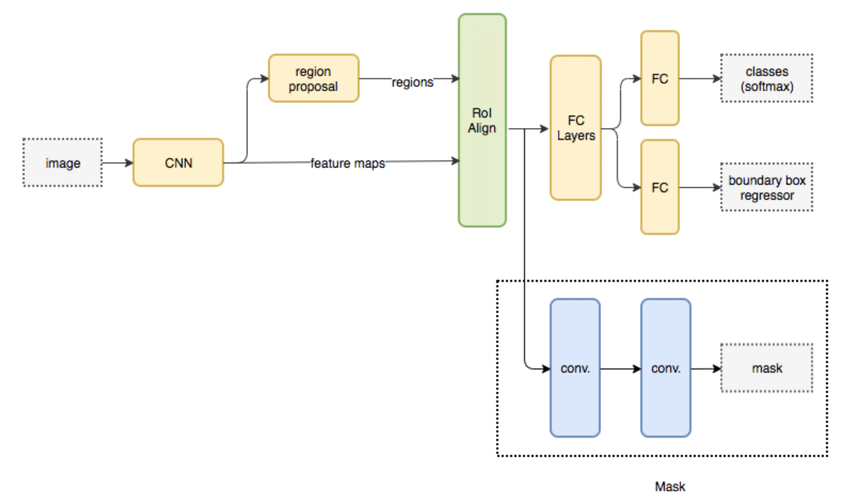

In [73]:
!git clone https://github.com/leekunhee/Mask_RCNN.git --quiet
!cd Mask_RCNN && python setup.py install --quiet

/opt/conda/lib/python3.7/site-packages/setuptools/dist.py:726: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt)
/opt/conda/lib/python3.7/site-packages/setuptools/dist.py:726: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt)
/opt/conda/lib/python3.7/site-packages/setuptools/dist.py:726: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt)
running install
/opt/conda/lib/python3.7/site-packages/setuptools/command/install.py:37: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  setuptools.SetuptoolsDeprecationWarning,
/opt/conda/lib/python3.7/s

In [74]:
# Fix seeds and create tensorflow session for reproducible results
SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-05-25 00:01:16.413074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:01:16.415177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:01:16.416398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:01:16.417306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:01:16.418103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [75]:
try:
    # TPU detection
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # By default, GPU or CPU
    strategy = tf.distribute.get_strategy()

In [76]:

import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN")#("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
COCO_MODEL_PATH = '../input/mask-rcnn-coco-weights/mask_rcnn_coco.h5'
# Download COCO trained weights from Releases if needed
if TRAIN:
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

In [77]:
class VocConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "voc_segmentation"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1#int(params['batch_size']/GPU_COUNT)

    # Number of classes (including background)
    NUM_CLASSES = params['num_classes']#1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = params["image_size"][0]
    IMAGE_MAX_DIM = params["image_size"][0]

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = VocConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                33
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [78]:
labels

Index(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
       'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'],
      dtype='object')

In [79]:
class MRCNNVocDataset(utils.Dataset):
    def load_dataset(self, dataset, labels=labels):
        self.dataset = dataset

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        image = self.dataset.loc[image_id, "img"]
        image = tf.cast(tf.image.resize(image, params['image_size'][:2], method='nearest'), dtype=tf.float32)
        return image


    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        mask = self.dataset.loc[image_id, "seg"]
        mask = tf.cast(tf.image.resize(mask[..., tf.newaxis], params['image_size'][:2], method='nearest'), dtype=tf.int64)
        class_ids = np.array([0] + [i + 1 for i in range(len(self.dataset.columns[:-2])) if self.dataset.iloc[image_id, i] == 1])
        return mask, class_ids

In [80]:
if TRAIN:
    mrcnn_train_set = MRCNNVocDataset()
    mrcnn_train_set.load_dataset(train_set)
    mrcnn_validation_set = MRCNNVocDataset()
    mrcnn_validation_set.load_dataset(validation_set)

In [81]:
mrcnn_test_set = MRCNNVocDataset()
mrcnn_test_set.load_dataset(test_df)

In [82]:
if TRAIN:    
    with strategy.scope():
        # Create model in training mode
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=MODEL_DIR)

In [83]:
if TRAIN:
    with strategy.scope():
        # Which weights to start with?
        init_with = "coco"  # imagenet, coco, or last

        if init_with == "imagenet":
            model.load_weights(model.get_imagenet_weights(), by_name=True)
        elif init_with == "coco":
            # Load weights trained on MS COCO, but skip layers that
            # are different due to the different number of classes
            # See README for instructions to download the COCO weights
            model.load_weights(COCO_MODEL_PATH, by_name=True)

        elif init_with == "last":
            # Load the last model you trained and continue training
            model.load_weights(model.find_last(), by_name=True)

In [84]:
if TRAIN:
    with strategy.scope():
        # Train the head branches
        # Passing layers="heads" freezes all layers except the head
        # layers. You can also pass a regular expression to select
        # which layers to train by name pattern.
        model.train(mrcnn_train_set, mrcnn_validation_set,#train_loader, validation_loader, 
                    learning_rate=config.LEARNING_RATE, 
                    epochs=1, 
                    layers='heads')

In [85]:
# class InferenceConfig(VocConfig):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# inference_config = InferenceConfig()

# # Recreate the model in inference mode
# model = modellib.MaskRCNN(mode="inference", 
#                           config=inference_config,
#                           model_dir=MODEL_DIR)

# # Get path to saved weights
# # Either set a specific path or find last trained weights
# # model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()

# # Load trained weights
# print("Loading weights from ", model_path)
# model.load_weights(model_path, by_name=True)

In [86]:
# # Test on a random image
# image_id = random.choice(dataset_val.image_ids)
# original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#     modellib.load_image_gt(dataset_val, inference_config, 
#                            image_id, use_mini_mask=False)

# log("original_image", original_image)
# log("image_meta", image_meta)
# log("gt_class_id", gt_class_id)
# log("gt_bbox", gt_bbox)
# log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))

In [87]:
# results = model.detect([original_image], verbose=1)

# r = results[0]
# visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                             dataset_val.class_names, r['scores'], ax=get_ax())

## Submit to competition
You don't need to edit this section. Just use it at the right position in the notebook. See the definition of this function in Sect. 1.3 for more details.

In [88]:
submission = pd.read_csv('../input/submission/final_aug_120.csv')
submission.to_csv('submission.csv', index=False)

In [89]:
# generate_submission(test_df)

## 3.6. Discussion

There are two different types of image segmentation:
* Semantic segmentation
* Instance segmentation

The difference between the two is that with semantic segmentation, each pixel in an image gets assigned to a class label, and with instance segmentation multiple objects of the same class are treated as distinct individual instances.

We tried three different models to perform image segmentation:
* Unet
* Mask R-CNN
* DeepLabV3+

We did not choose these models at random. We first tried a semantic segmentation approach, which was Unet. But after obtaining only poor results from our Unet implementation, we started looking for a different approach. So we implemented Mask R-CNN, which is an instance segmentation approach. And we started seeing a lot better results. At the same time, we also went looking for another semantic segmentation approach, and found DeepLabV3+. 

# 4. Adversarial attack
For this part, your goal is to fool your classification and/or segmentation CNN, using an *adversarial attack*. More specifically, the goal is build a CNN to perturb test images in a way that (i) they look unperturbed to humans; but (ii) the CNN classifies/segments these images in line with the perturbations.

**White-box attacks** usually allow one to better fool a neural network than black-box attacks. An adversarial model built for such attacks usually learns thanks to the gradients of the model under attack and thereby rely on a free access to the neural network architecture. This scenario is very unlikely (except in open source scenarios) as companies typically hide it from the public to protect their intellectual property and maintain a technological advantage over their rivals. White-box attacks could however be used to produce adversarial samples and train the model to make it more robust to future attacks.

**Black-box attacks** are more likely to be harmful as they generate adversarial examples solely based on observing output labels returned by the model. This scenario often relies on many queries sent to the black-box model and in practice companies can defend themselves by limiting the query rates or the number of queries they answer.

**Other Defensive Mechanisms**: 

On top of the techniques already cited above, one can make his model more robust with 
- **regularization techniques** (normalization, noise reduction, compression, data augmentation, ...) to avoid large gradients on the inputs that make networks vulnerable to attacks
- **model ensembling** that combines the prediction of multiple models, each trained independently with their own architecture, loss gradients, ... The ensemble model is then more robust.
- **gradient masking** which refers to techniques to hide the gradients of a neural network from the attacker. In this way attackers ca not find the boundaries between two image classes. No gradient descent or ascent is possible to find the best way to produce misclassified images. For instance, let us consider a classification models that, when given an image, outputs the probabilities of its 5 most likely labels. Simple gradient masking can be achieved by only showing the 5 most likely labels without their probability (or even better only the most likely label). In this way, it is way more difficult for the attacker to get insights on the gradient when probing the classifier. Indeed, the attacker will not know from one query to another whether the small perturbation decreased the probability of the true label. It will only get positive feedback on the effect of its attacks when the label changes.
- ...

**Problem Formulation :**

We decided to experiment with the second scenario (black-box model) to get an idea of how dangerous real-world adversarial attacks could be. Given that black-box attacks are way less effective than white-box attacks, we decided to try an **untargeted attack** on an image for which our neural network classifier predicts correctly its labels and yet **has not seen the image during training or validation**. As such, the goal of the attack is reached if the labels are not perfectly predicted by the model (i.e. at least 1 label too many or 1 label too few or 1 wrong label in the multi-label prediction) and the perturbed image is not too far from the initial example. We also try to obtain an effective attack with as few queries as possible.

## 4.1. Load Classifier

In [90]:
# Fix seeds and create tensorflow session for reproducible results
SEED = 42
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-05-25 00:01:32.077562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:01:32.078866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:01:32.079562: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:01:32.080333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 00:01:32.081108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

## 4.2. Hop Skip Jump Attack
Efficient black-box attack algorithm:
- Paper: https://arxiv.org/pdf/1904.02144.pdf
- GitHub: https://github.com/Jianbo-Lab/HSJA

The code below comes from the GitHub repository but we adapted it to handle attacks on multi-label classifiers.


HopSkipJumpAttack is a family of algorithms that is iterative in nature. Each iteration has three steps:

1. Perform binary search to find the boundary between a successful and unsuccessful perturbation.
2. Find the gradient descend direction via a Monte Carlo estimate.
3. The updating step size along the gradient direction is initialized, and is decreased via geometric progression until the perturbation becomes successful. The next iteration starts with projecting the perturbed sample back to the boundary again.

In [91]:
from __future__ import absolute_import, division, print_function
import numpy as np

def hsja(model, 
    sample, 
    clip_max = 1, 
    clip_min = 0, 
    constraint = 'l2', 
    num_iterations = 40, 
    gamma = 1.0, 
    target_label = None, 
    target_image = None, 
    stepsize_search = 'geometric_progression', 
    max_num_evals = 1e4,
    init_num_evals = 100,
    verbose = True):
    """
    Main algorithm for HopSkipJumpAttack.
    Inputs:
    model: the object that has predict method. 
    predict outputs probability scores.
    clip_max: upper bound of the image.
    clip_min: lower bound of the image.
    constraint: choose between [l2, linf].
    num_iterations: number of iterations.
    gamma: used to set binary search threshold theta. The binary search 
    threshold theta is gamma / d^{3/2} for l2 attack and gamma / d^2 for 
    linf attack.
    target_label: integer or None for nontargeted attack.
    target_image: an array with the same size as sample, or None. 
    stepsize_search: choose between 'geometric_progression', 'grid_search'.
    max_num_evals: maximum number of evaluations for estimating gradient (for each iteration). 
    This is not the total number of model evaluations for the entire algorithm, you need to 
    set a counter of model evaluations by yourself to get that. To increase the total number 
    of model evaluations, set a larger num_iterations. 
    init_num_evals: initial number of evaluations for estimating gradient.
    Output:
    perturbed image.

    """
    # Set parameters
    original_label = model.predict(sample) #np.argmax(model.predict(sample))
#     print(original_label)
    params = {'clip_max': clip_max, 'clip_min': clip_min, 
                'shape': sample.shape,
                'original_label': original_label, 
                'target_label': target_label,
                'target_image': target_image, 
                'constraint': constraint,
                'num_iterations': num_iterations, 
                'gamma': gamma, 
                'd': int(np.prod(sample.shape)), 
                'stepsize_search': stepsize_search,
                'max_num_evals': max_num_evals,
                'init_num_evals': init_num_evals,
                'verbose': verbose,
                }

    # Set binary search threshold.
    if params['constraint'] == 'l2':
        params['theta'] = params['gamma'] / (np.sqrt(params['d']) * params['d'])
    else:
        params['theta'] = params['gamma'] / (params['d'] ** 2)

    # Initialize.
    perturbed = initialize(model, sample, params)


    # Project the initialization to the boundary.
    perturbed, dist_post_update = binary_search_batch(sample, 
        np.expand_dims(perturbed, 0), 
        model, 
        params)
    dist = compute_distance(perturbed, sample, constraint)

    for j in np.arange(params['num_iterations']):
        params['cur_iter'] = j + 1

        # Choose delta.
        delta = select_delta(params, dist_post_update)

        # Choose number of evaluations.
        num_evals = int(params['init_num_evals'] * np.sqrt(j+1))
        num_evals = int(min([num_evals, params['max_num_evals']]))

        # approximate gradient.
        gradf = approximate_gradient(model, perturbed, num_evals, 
            delta, params)
        if params['constraint'] == 'linf':
            update = np.sign(gradf)
        else:
            update = gradf

        # search step size.
        if params['stepsize_search'] == 'geometric_progression':
            # find step size.
            epsilon = geometric_progression_for_stepsize(perturbed, 
                update, dist, model, params)

            # Update the sample. 
            perturbed = clip_image(perturbed + epsilon * update, 
                clip_min, clip_max)

            # Binary search to return to the boundary. 
            perturbed, dist_post_update = binary_search_batch(sample, 
                perturbed[None], model, params)

        elif params['stepsize_search'] == 'grid_search':
            # Grid search for stepsize.
            epsilons = np.logspace(-4, 0, num=20, endpoint = True) * dist
            epsilons_shape = [20] + len(params['shape']) * [1]
            perturbeds = perturbed + epsilons.reshape(epsilons_shape) * update
            perturbeds = clip_image(perturbeds, params['clip_min'], params['clip_max'])
            idx_perturbed = decision_function(model, perturbeds, params)

            if np.sum(idx_perturbed) > 0:
                # Select the perturbation that yields the minimum distance # after binary search.
                perturbed, dist_post_update = binary_search_batch(sample, 
                    perturbeds[idx_perturbed], model, params)

        # compute new distance.
        dist = compute_distance(perturbed, sample, constraint)
        if verbose:
            print('iteration: {:d}, {:s} distance {:.4E}'.format(j+1, constraint, dist))

    return perturbed

def decision_function(model, images, params):
    """
    Decision function output 1 on the desired side of the boundary,
    0 otherwise.
    """
    images = clip_image(images, params['clip_min'], params['clip_max'])
    new_labels = model.predict(images[0]) 
    if params['target_label'] is None:
        return np.array([new_labels[0] != params['original_label'][0]]) 
    else:
        return np.array([new_labels[0] == params['target_label'][0]])

def clip_image(image, clip_min, clip_max):
    # Clip an image, or an image batch, with upper and lower threshold.
    return np.minimum(np.maximum(clip_min, image), clip_max) 


def compute_distance(x_ori, x_pert, constraint = 'l2'):
    # Compute the distance between two images.
    if constraint == 'l2':
        return np.linalg.norm(x_ori - x_pert)
    elif constraint == 'linf':
        return np.max(abs(x_ori - x_pert))


def approximate_gradient(model, sample, num_evals, delta, params):
    clip_max, clip_min = params['clip_max'], params['clip_min']

    # Generate random vectors.
    noise_shape = [num_evals] + list(params['shape'])
    if params['constraint'] == 'l2':
        rv = np.random.randn(*noise_shape)
    elif params['constraint'] == 'linf':
        rv = np.random.uniform(low = -1, high = 1, size = noise_shape)

    rv = rv / np.sqrt(np.sum(rv ** 2, axis = (1,2,3), keepdims = True))
    perturbed = sample + delta * rv
    perturbed = clip_image(perturbed, clip_min, clip_max)
    rv = (perturbed - sample) / delta
    
    # query the model.
    decisions = decision_function(model, perturbed, params)
    decision_shape = [len(decisions)] + [1] * len(params['shape'])
    fval = 2 * decisions.astype(float).reshape(decision_shape) - 1.0

    # Baseline subtraction (when fval differs)
    if np.mean(fval) == 1.0: # label changes. 
        gradf = np.mean(rv, axis = 0)
    elif np.mean(fval) == -1.0: # label not change.
        gradf = - np.mean(rv, axis = 0)
    else:
        fval -= np.mean(fval)
        gradf = np.mean(fval * rv, axis = 0) 

    # Get the gradient direction.
    gradf = gradf / np.linalg.norm(gradf)

    return gradf


def project(original_image, perturbed_images, alphas, params):
    alphas_shape = [len(alphas)] + [1] * len(params['shape'])
    alphas = alphas.reshape(alphas_shape)
    if params['constraint'] == 'l2':
        return (1-alphas) * original_image + alphas * perturbed_images
    elif params['constraint'] == 'linf':
        out_images = clip_image(
            perturbed_images, 
            original_image - alphas, 
            original_image + alphas
            )
        return out_images


def binary_search_batch(original_image, perturbed_images, model, params):
    """ Binary search to approach the boundar. """

    # Compute distance between each of perturbed image and original image.
    dists_post_update = np.array([
            compute_distance(
                original_image, 
                perturbed_image, 
                params['constraint']
            ) 
            for perturbed_image in perturbed_images])

    # Choose upper thresholds in binary searchs based on constraint.
    if params['constraint'] == 'linf':
        highs = dists_post_update
        # Stopping criteria.
        thresholds = np.minimum(dists_post_update * params['theta'], params['theta'])
    else:
        highs = np.ones(len(perturbed_images))
        thresholds = params['theta']

    lows = np.zeros(len(perturbed_images))



    # Call recursive function. 
    while np.max((highs - lows) / thresholds) > 1:
        # projection to mids.
        mids = (highs + lows) / 2.0
        mid_images = project(original_image, perturbed_images, mids, params)

        # Update highs and lows based on model decisions.
        decisions = decision_function(model, mid_images, params)
        lows = np.where(decisions == 0, mids, lows)
        highs = np.where(decisions == 1, mids, highs)

    out_images = project(original_image, perturbed_images, highs, params)

    # Compute distance of the output image to select the best choice. 
    # (only used when stepsize_search is grid_search.)
    dists = np.array([
        compute_distance(
            original_image, 
            out_image, 
            params['constraint']
        ) 
        for out_image in out_images])
    idx = np.argmin(dists)

    dist = dists_post_update[idx]
    out_image = out_images[idx]
    return out_image, dist


def initialize(model, sample, params):
    """ 
    Efficient Implementation of BlendedUniformNoiseAttack in Foolbox.
    """
    success = 0
    num_evals = 0

    if params['target_image'] is None:
        # Find a misclassified random noise.
        while True:
            random_noise = np.random.uniform(params['clip_min'], 
                params['clip_max'], size = params['shape'])
            success = decision_function(model,random_noise[None], params)[0]
            num_evals += 1
            if success:
                break
            assert num_evals < 1e4,"Initialization failed! "
            "Use a misclassified image as `target_image`" 


        # Binary search to minimize l2 distance to original image.
        low = 0.0
        high = 1.0
        while high - low > 0.001:
            mid = (high + low) / 2.0
            blended = (1 - mid) * sample + mid * random_noise 
            success = decision_function(model, blended[None], params)
            if success:
                high = mid
            else:
                low = mid

        initialization = (1 - high) * sample + high * random_noise 

    else:
        initialization = params['target_image']

    return initialization


def geometric_progression_for_stepsize(x, update, dist, model, params):
    """
    Geometric progression to search for stepsize.
    Keep decreasing stepsize by half until reaching 
    the desired side of the boundary,
    """
    epsilon = dist / np.sqrt(params['cur_iter']) 

    def phi(epsilon):
        new = x + epsilon * update
        success = decision_function(model, new[None], params)
        return success

    while not phi(epsilon):
        epsilon /= 2.0

    return epsilon

def select_delta(params, dist_post_update):
    """ 
    Choose the delta at the scale of distance 
    between x and perturbed sample. 
    """
    if params['cur_iter'] == 1:
        delta = 0.1 * (params['clip_max'] - params['clip_min'])
    else:
        if params['constraint'] == 'l2':
            delta = np.sqrt(params['d']) * params['theta'] * dist_post_update
        elif params['constraint'] == 'linf':
            delta = params['d'] * params['theta'] * dist_post_update	

    return delta

In [92]:
class BlackBoxClassificationModel():
    def predict(self, X):
        return classification_model.predict(np.expand_dims(X, axis=0))
black_box_classification_model = BlackBoxClassificationModel()

### Test Loader

Initial image classified correctly as a sofa by our classifer

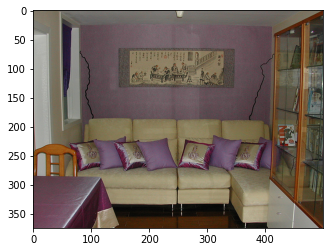

In [93]:
plt.imshow(classification_test_loader[2][0][0])

In [94]:
if TRAIN:
    black_box_classification_model.predict(classification_test_loader[2][0][0])

In [95]:
if TRAIN:
    perturbed = hsja(black_box_classification_model,
                    classification_test_loader[2][0][0],
                    clip_max = 255,#1, 
                    clip_min = 0, 
                    constraint = 'l2', #'linf'
                    num_iterations = 7, #40,
                    gamma = 1.0, 
                    target_label = None,
                    target_image = None,
                    stepsize_search = 'geometric_progression', 
                    max_num_evals = 1e4,
                    init_num_evals = 100,
                    verbose=True)

Perturbed image not classified correctly anymore

In [96]:
if TRAIN:
    black_box_classification_model.predict(perturbed)

In [97]:
if TRAIN:
    plt.imshow(perturbed)

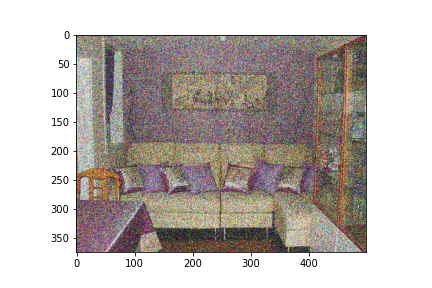

We see that in a decent computing time we manage to fool the network by adding some noise to the image. The image remains recognisable to the human eye. We can however notice the noise that was added. It would thus allow a human operator to detect the adversarial attack. It however remains very deceptive as we could mistake this adversarial sample for a simple low-quality image.

Our classifier could thus be unreliable if we let a malicious bot perform enough queries to build adversarial samples. We have however mentioned before several techniques to prevent this from happening. It nevertheless raises some concerns about the viability of neural networks in sensitive sectors (eg: health, safety, security, finance, ...). Carefull consideration of the context and appropriate preventive measures should be envisioned to make reliable use of neural networks.

# 5. Discussion
## 5.1 Image Classification
We started this script with a section on image classification where we compared a custom and a transfer model. Using the pretrained features of other models that are trained on huge datasets is almost always the best option (unless you have a more niche application). The transfer model then has less trainable parameters and less layers with tuneable parameters. This speeds up the time needed for training and designing an architecture and thus frees up time to spent on more advanced features like data augmentation, regularization, etc... It also allows one to obtain decent to very good results with limited training data which is especially useful in applications where building up a dataset is costly and time-consuming.

## 5.2 Segmentation
We started with Unet as our image segmentation approach, but Unet didn't deliver good results so we proceeded to also test other approaches. We tested two other approaches, called Mask R-CNN and DeepLabV3+. They delivered better results, but still after some optimisation we still didn't achieve the results we hoped for. For us to deploy the model into the "real world", we would need a lot more training data to fully optimise our model. With more training data we could also make our model more robust to protect against potential adversarial attacks.

## 5.3 Adversarial attacks
Confusing a neural net is easier then it might seem. Even small perturbations can produce different outputs. But when the model weights are known, fooling the model is actually easier because you have direct access to the gradients. Because we wanted to simulate a more real-life scenario we opted for the blackbox approach. Even then, it is actually possible to build up an approximation of the gradients with sufficient probes. We experimented with the Hop Skip Jump algorithm. This taught us that an outsider can mislead the network, even without knowing its inner workings. It shows that CNNs are not perfect computer vision solution. When using them, we should always bear their disadvantages or weaknesses in mind and implement robustness measures adapted to the specific application at hand.

## 5.4 CNN in the computer vision landscape
With the dawn of deep learning, CNNs initiated a revolution in the computer vision world, reaching unimagined results and they have been rapidly improving since then. The main advantage of CNNs is to flexibility learn features in any applications. The best features for the task at hand are discovered by the network itself. Other feature detectors like Histogram Of Gradients and SIFT work well within ranges, but are predesigned features. Ultimately a well-trained CNN would outperform SIFT or HOG-methods if given sufficient data.

Of course this begs the question of how to obtain a well-trained CNN. The data requierments are often huge. Training a CNN is also a non-convex problem and enough care should be taken in tuning parameters. Additionaly CNNs are still sensitive to adversarial attacks and are not always that robust to noise. Application-specific measures have to be put in place to ensure their reliable use. For all these reasons training a neural network is time-intensive work. 


That is why classical methods still prove to be usefull and can be more straightforward to implement. 

However, with tools and libraries like kaggle, pytorch, tensorflow and keras it has never been easier to experiment with deep learning on your own and results can be impressive.